# Satellite image classification



### Setup

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_DIR = '../data/cloud-classif/'
IMG_DIR = os.path.join(DATA_DIR, 'jpg/')
CHECKPOINTS_DIR = 'checkpoints'

In [3]:
import time
import mxnet as mx
from mxnet import gluon
from mxnet.gluon.model_zoo import vision
from mxnet.image import color_normalize
from mxnet.gluon.data.vision import ImageRecordDataset

We'll run in the GPU

In [4]:
ctx = mx.gpu(0)

Use data augmentation to generate some more samples. Using horizontal flip, saturation and contrast because they shouldn't alter the nature of our cloud/not cloud data.  


In [5]:
train_augs = [
     mx.image.HorizontalFlipAug(0.5),
     mx.image.SaturationJitterAug(.1),
     mx.image.ContrastJitterAug(.1),
     mx.image.RandomCropAug((224, 224))
]

test_augs = [
    image.CenterCropAug((224, 224))
]

def transform(data, label, augs):
    data = data.astype('float32')
    for aug in augs:
        data = aug(data)
    data = mx.nd.transpose(data, (2,0,1))
    return data, mx.nd.array([label]).asscalar().astype('float32')

Train and validation sets come from the 'Planet: Understanding the Amazon from Space' Kaggle competition, test dataset is made of Sentinel-2 images.

In [6]:
train_rec = os.path.join(DATA_DIR, 'train/clouds.rec')
valid_rec = os.path.join(DATA_DIR, 'valid/clouds.rec')
test_rec  = os.path.join(DATA_DIR, 'test/s2test.rec')

trainIterator = ImageRecordDataset(
    filename=train_rec, 
    transform=lambda X, y: transform(X, y, train_augs)
)
validIterator = ImageRecordDataset(
    filename=valid_rec, 
    transform=lambda X, y: transform(X, y, train_augs)
)
testIterator = ImageRecordDataset(
    filename=test_rec,
    transform=lambda X, y: transform(X, y, test_augs)
)

When using pretrained networks from Gluon's model zoo, we'll need to normalize input images using this mean and std.

In [7]:
mean = mx.nd.array([0.485, 0.456, 0.406], ctx=ctx).reshape((1,3,1,1))
std =  mx.nd.array([0.229, 0.224, 0.225], ctx=ctx).reshape((1,3,1,1))

### Training

First of all, define functions for training

In [8]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        data = color_normalize(data/255, mean, std)
        output = net(data)
        prediction = mx.nd.argmax(output, axis=1)
        acc.update(preds=prediction, labels=label)
    return acc.get()[1]


def metric_str(names, accs):
    return ', '.join(['%s=%f'%(name, acc) for name, acc in zip(names, accs)])


def train_util(net, train_iter, validation_iter, loss_fn,
               trainer, ctx, epochs, batch_size, checkpoint_dir, init_epoch=0):
    '''
    Function to train the neural network.
    
    PARAMS:
    - net: network to train
    - train_iter: gluon.data.DataLoader with the training data
    - validation_iter: "                      "  validation data
    - loss_fn: loss function to use for training
    - trainer: gluon.Trainer to use for training
    - ctx: context where we will operate (GPU or CPU)
    - epochs: number of epochs to train for
    - batch_size
    - checkpoint_dir: directory where checkpoints are saved every 100 batches
    - init_epoch: set to the initial epoch in case training is resumed from a previous execution'''
    
    res = {'train':[],'valid':[]}
    for epoch in range(1+init_epoch, epochs+init_epoch+1):
        metric = mx.metric.create(['acc'])
        for i, (data, label) in enumerate(train_iter):
            st = time.time()
            # ensure context            
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            # normalize images
            data = color_normalize(data/255, mean, std)
            
            with mx.autograd.record():
                output = net(data)
                loss = loss_fn(output, label)

            loss.backward()
            trainer.step(data.shape[0], ignore_stale_grad=True)
            
            #  Keep a moving average of the losses
            metric.update([label], [output])
            names, accs = metric.get()
            if i%5 == 0:
                print('[Epoch %d Batch %d] speed: %f samples/s, training: %s'%(epoch, i, batch_size/(time.time()-st), metric_str(names, accs)))
            if i%100 == 0:
                net.save_params('%s/%d-%d.params'%(checkpoint_dir, epoch, i))
                # Store accuracy and reset the metric
                metric.reset()
                if i != 0:
                    res['train'].append(accs)

        names, train_acc = metric.get()
        validation_acc = evaluate_accuracy(validation_iter, net)
        res['train'].append(train_acc)
        res['valid'].append(validation_acc)
        print("Epoch %s | training_acc %s | val_acc %s " % (epoch, train_acc, validation_acc))
        
    return res

In [9]:
def train(net, ctx, batch_size=32, epochs=10, learning_rate=0.01, wd=0.001, momentum=0,
          checkpoint_dir='checkpoints', params=None, init_epoch=0):
    train_data = gluon.data.DataLoader(
        trainIterator, batch_size, shuffle=True)
    
    valid_data = gluon.data.DataLoader(
        validIterator, batch_size)
    
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params() if not params else params, 'adam', 
            {'learning_rate': learning_rate})
    
    return train_util(net, train_data, valid_data, 
               loss, trainer, ctx, epochs, batch_size,
               checkpoint_dir, init_epoch=init_epoch)
    

We will train two different networks to compare their performances. The first of them, and also the simplest, is a MobileNet. The second one is a ResNet50.

#### MobileNet

In [11]:
checkpoints = os.path.join(CHECKPOINTS_DIR, 'mobilenet')
os.makedirs(checkpoints, exist_ok=True)

# Load the pretrained network
pretrained_mobilenet = vision.mobilenet1_0(pretrained=True) 

# Load the network to train, using the same prefix to avoid problems when saving and loading params,
# as we will assign the features part of the pretrained network to this one
mobilenet = vision.mobilenet1_0(classes=4, prefix=pretrained_mobilenet.prefix)
mobilenet.features = pretrained_mobilenet.features
mobilenet.output.initialize(mx.init.Xavier())

In [12]:
# Train and save the accuracy scores
mobilenet_acc = train(mobilenet, ctx, batch_size=32, epochs=10, learning_rate=0.003, checkpoint_dir=checkpoints)
np.save(checkpoints + '/accuracy-results.npy', mobilenet_acc) 

[Epoch 1 Batch 0] speed: 43.226433 samples/s, training: accuracy=0.156250
[Epoch 1 Batch 5] speed: 1342.418915 samples/s, training: accuracy=0.593750
[Epoch 1 Batch 10] speed: 1376.436792 samples/s, training: accuracy=0.675000
[Epoch 1 Batch 15] speed: 1256.449716 samples/s, training: accuracy=0.681250
[Epoch 1 Batch 20] speed: 1306.649481 samples/s, training: accuracy=0.695312
[Epoch 1 Batch 25] speed: 1200.903046 samples/s, training: accuracy=0.720000
[Epoch 1 Batch 30] speed: 1235.390155 samples/s, training: accuracy=0.728125
[Epoch 1 Batch 35] speed: 1266.443933 samples/s, training: accuracy=0.733929
[Epoch 1 Batch 40] speed: 1255.556441 samples/s, training: accuracy=0.744531
[Epoch 1 Batch 45] speed: 1283.397667 samples/s, training: accuracy=0.754861
[Epoch 1 Batch 50] speed: 1279.531422 samples/s, training: accuracy=0.766250
[Epoch 1 Batch 55] speed: 1303.312501 samples/s, training: accuracy=0.775568
[Epoch 1 Batch 60] speed: 1289.278196 samples/s, training: accuracy=0.779687
[Ep

[Epoch 1 Batch 530] speed: 1297.416414 samples/s, training: accuracy=0.870833
[Epoch 1 Batch 535] speed: 1226.774594 samples/s, training: accuracy=0.878571
[Epoch 1 Batch 540] speed: 1131.741302 samples/s, training: accuracy=0.881250
[Epoch 1 Batch 545] speed: 1278.324949 samples/s, training: accuracy=0.879167
[Epoch 1 Batch 550] speed: 1302.503037 samples/s, training: accuracy=0.878750
[Epoch 1 Batch 555] speed: 1254.277512 samples/s, training: accuracy=0.875568
[Epoch 1 Batch 560] speed: 1228.144100 samples/s, training: accuracy=0.874479
[Epoch 1 Batch 565] speed: 1281.669656 samples/s, training: accuracy=0.873077
[Epoch 1 Batch 570] speed: 1291.486437 samples/s, training: accuracy=0.874107
[Epoch 1 Batch 575] speed: 1245.177920 samples/s, training: accuracy=0.875000
[Epoch 1 Batch 580] speed: 1286.657988 samples/s, training: accuracy=0.875781
[Epoch 1 Batch 585] speed: 1182.212154 samples/s, training: accuracy=0.878309
[Epoch 1 Batch 590] speed: 1263.297014 samples/s, training: accu

[Epoch 2 Batch 105] speed: 1167.039641 samples/s, training: accuracy=0.875000
[Epoch 2 Batch 110] speed: 1293.465374 samples/s, training: accuracy=0.884375
[Epoch 2 Batch 115] speed: 1330.930914 samples/s, training: accuracy=0.887500
[Epoch 2 Batch 120] speed: 1330.390024 samples/s, training: accuracy=0.893750
[Epoch 2 Batch 125] speed: 1258.310861 samples/s, training: accuracy=0.896250
[Epoch 2 Batch 130] speed: 1255.298099 samples/s, training: accuracy=0.890625
[Epoch 2 Batch 135] speed: 1257.108732 samples/s, training: accuracy=0.891071
[Epoch 2 Batch 140] speed: 1239.829366 samples/s, training: accuracy=0.891406
[Epoch 2 Batch 145] speed: 1248.269933 samples/s, training: accuracy=0.888889
[Epoch 2 Batch 150] speed: 1254.453357 samples/s, training: accuracy=0.888125
[Epoch 2 Batch 155] speed: 1276.416312 samples/s, training: accuracy=0.890909
[Epoch 2 Batch 160] speed: 1055.901315 samples/s, training: accuracy=0.888542
[Epoch 2 Batch 165] speed: 1312.347619 samples/s, training: accu

[Epoch 2 Batch 635] speed: 1307.718887 samples/s, training: accuracy=0.897321
[Epoch 2 Batch 640] speed: 1281.045776 samples/s, training: accuracy=0.901563
[Epoch 2 Batch 645] speed: 1269.210376 samples/s, training: accuracy=0.903472
[Epoch 2 Batch 650] speed: 1245.039313 samples/s, training: accuracy=0.900625
[Epoch 2 Batch 655] speed: 1258.747496 samples/s, training: accuracy=0.898295
[Epoch 2 Batch 660] speed: 1233.641501 samples/s, training: accuracy=0.897917
[Epoch 2 Batch 665] speed: 1261.243298 samples/s, training: accuracy=0.899519
[Epoch 2 Batch 670] speed: 1253.668298 samples/s, training: accuracy=0.896429
[Epoch 2 Batch 675] speed: 1296.489007 samples/s, training: accuracy=0.899167
[Epoch 2 Batch 680] speed: 1256.426192 samples/s, training: accuracy=0.898438
[Epoch 2 Batch 685] speed: 1275.445948 samples/s, training: accuracy=0.899265
[Epoch 2 Batch 690] speed: 1271.844291 samples/s, training: accuracy=0.897569
[Epoch 2 Batch 695] speed: 1211.187366 samples/s, training: accu

[Epoch 3 Batch 210] speed: 1326.039381 samples/s, training: accuracy=0.896875
[Epoch 3 Batch 215] speed: 1313.066594 samples/s, training: accuracy=0.912500
[Epoch 3 Batch 220] speed: 1303.236571 samples/s, training: accuracy=0.909375
[Epoch 3 Batch 225] speed: 1245.316558 samples/s, training: accuracy=0.916250
[Epoch 3 Batch 230] speed: 1254.125153 samples/s, training: accuracy=0.913542
[Epoch 3 Batch 235] speed: 1132.992816 samples/s, training: accuracy=0.908036
[Epoch 3 Batch 240] speed: 1287.287348 samples/s, training: accuracy=0.914844
[Epoch 3 Batch 245] speed: 1285.955314 samples/s, training: accuracy=0.918056
[Epoch 3 Batch 250] speed: 1314.365310 samples/s, training: accuracy=0.915625
[Epoch 3 Batch 255] speed: 1275.385349 samples/s, training: accuracy=0.915909
[Epoch 3 Batch 260] speed: 1261.527807 samples/s, training: accuracy=0.915104
[Epoch 3 Batch 265] speed: 1222.227840 samples/s, training: accuracy=0.914423
[Epoch 3 Batch 270] speed: 1313.940694 samples/s, training: accu

[Epoch 3 Batch 740] speed: 1278.897435 samples/s, training: accuracy=0.895312
[Epoch 3 Batch 745] speed: 1256.355627 samples/s, training: accuracy=0.896528
[Epoch 3 Batch 750] speed: 1283.078676 samples/s, training: accuracy=0.899375
[Epoch 3 Batch 755] speed: 1258.063176 samples/s, training: accuracy=0.901705
[Epoch 3 Batch 760] speed: 1166.542623 samples/s, training: accuracy=0.900000
[Epoch 3 Batch 765] speed: 1271.506925 samples/s, training: accuracy=0.901923
[Epoch 3 Batch 770] speed: 1262.643374 samples/s, training: accuracy=0.901339
[Epoch 3 Batch 775] speed: 1252.404897 samples/s, training: accuracy=0.902083
[Epoch 3 Batch 780] speed: 1214.618088 samples/s, training: accuracy=0.903516
[Epoch 3 Batch 785] speed: 1255.756142 samples/s, training: accuracy=0.903309
[Epoch 3 Batch 790] speed: 1267.508362 samples/s, training: accuracy=0.903472
[Epoch 3 Batch 795] speed: 1169.826711 samples/s, training: accuracy=0.900658
[Epoch 3 Batch 800] speed: 1276.792725 samples/s, training: accu

[Epoch 4 Batch 315] speed: 1260.781243 samples/s, training: accuracy=0.904167
[Epoch 4 Batch 320] speed: 1292.021024 samples/s, training: accuracy=0.909375
[Epoch 4 Batch 325] speed: 1318.574791 samples/s, training: accuracy=0.910000
[Epoch 4 Batch 330] speed: 1272.410986 samples/s, training: accuracy=0.912500
[Epoch 4 Batch 335] speed: 1272.459238 samples/s, training: accuracy=0.913393
[Epoch 4 Batch 340] speed: 1359.125576 samples/s, training: accuracy=0.913281
[Epoch 4 Batch 345] speed: 1224.614307 samples/s, training: accuracy=0.912500
[Epoch 4 Batch 350] speed: 1222.272361 samples/s, training: accuracy=0.911875
[Epoch 4 Batch 355] speed: 1253.387322 samples/s, training: accuracy=0.910227
[Epoch 4 Batch 360] speed: 1312.873934 samples/s, training: accuracy=0.907813
[Epoch 4 Batch 365] speed: 1298.483316 samples/s, training: accuracy=0.903365
[Epoch 4 Batch 370] speed: 1271.591250 samples/s, training: accuracy=0.906250
[Epoch 4 Batch 375] speed: 1165.651080 samples/s, training: accu

[Epoch 4 Batch 845] speed: 1247.399840 samples/s, training: accuracy=0.906944
[Epoch 4 Batch 850] speed: 1233.573472 samples/s, training: accuracy=0.905625
[Epoch 4 Batch 855] speed: 1325.201449 samples/s, training: accuracy=0.905682
[Epoch 4 Batch 860] speed: 1284.367882 samples/s, training: accuracy=0.904687
[Epoch 4 Batch 865] speed: 1185.344367 samples/s, training: accuracy=0.905769
[Epoch 4 Batch 870] speed: 1302.680022 samples/s, training: accuracy=0.907143
[Epoch 4 Batch 875] speed: 1304.756853 samples/s, training: accuracy=0.908333
[Epoch 4 Batch 880] speed: 1267.807681 samples/s, training: accuracy=0.903516
[Epoch 4 Batch 885] speed: 1224.748403 samples/s, training: accuracy=0.903676
[Epoch 4 Batch 890] speed: 1318.976484 samples/s, training: accuracy=0.897222
[Epoch 4 Batch 895] speed: 1279.068062 samples/s, training: accuracy=0.897368
[Epoch 4 Batch 900] speed: 1239.886633 samples/s, training: accuracy=0.896875
[Epoch 4 Batch 905] speed: 1271.374438 samples/s, training: accu

[Epoch 5 Batch 420] speed: 1258.464239 samples/s, training: accuracy=0.882812
[Epoch 5 Batch 425] speed: 1267.113478 samples/s, training: accuracy=0.871250
[Epoch 5 Batch 430] speed: 1225.318641 samples/s, training: accuracy=0.867708
[Epoch 5 Batch 435] speed: 1234.833228 samples/s, training: accuracy=0.875893
[Epoch 5 Batch 440] speed: 1245.559249 samples/s, training: accuracy=0.877344
[Epoch 5 Batch 445] speed: 1271.651488 samples/s, training: accuracy=0.885417
[Epoch 5 Batch 450] speed: 1300.899732 samples/s, training: accuracy=0.885625
[Epoch 5 Batch 455] speed: 1205.032528 samples/s, training: accuracy=0.888068
[Epoch 5 Batch 460] speed: 1252.171213 samples/s, training: accuracy=0.889062
[Epoch 5 Batch 465] speed: 1202.689367 samples/s, training: accuracy=0.891827
[Epoch 5 Batch 470] speed: 1188.598471 samples/s, training: accuracy=0.894196
[Epoch 5 Batch 475] speed: 1294.226199 samples/s, training: accuracy=0.893333
[Epoch 5 Batch 480] speed: 1278.118006 samples/s, training: accu

Epoch 5 | training_acc [0.9134993446920052] | val_acc 0.9063241106719367 
[Epoch 6 Batch 0] speed: 1269.654609 samples/s, training: accuracy=0.843750
[Epoch 6 Batch 5] speed: 1246.924702 samples/s, training: accuracy=0.906250
[Epoch 6 Batch 10] speed: 1166.198002 samples/s, training: accuracy=0.903125
[Epoch 6 Batch 15] speed: 1304.807591 samples/s, training: accuracy=0.897917
[Epoch 6 Batch 20] speed: 1318.160398 samples/s, training: accuracy=0.901563
[Epoch 6 Batch 25] speed: 1306.522287 samples/s, training: accuracy=0.897500
[Epoch 6 Batch 30] speed: 1285.118039 samples/s, training: accuracy=0.892708
[Epoch 6 Batch 35] speed: 1305.645324 samples/s, training: accuracy=0.893750
[Epoch 6 Batch 40] speed: 1255.544696 samples/s, training: accuracy=0.892969
[Epoch 6 Batch 45] speed: 1264.880437 samples/s, training: accuracy=0.893750
[Epoch 6 Batch 50] speed: 1253.469260 samples/s, training: accuracy=0.897500
[Epoch 6 Batch 55] speed: 1225.016684 samples/s, training: accuracy=0.891477
[Epo

[Epoch 6 Batch 525] speed: 1259.078124 samples/s, training: accuracy=0.910000
[Epoch 6 Batch 530] speed: 1261.089242 samples/s, training: accuracy=0.908333
[Epoch 6 Batch 535] speed: 1249.222625 samples/s, training: accuracy=0.909821
[Epoch 6 Batch 540] speed: 1222.361414 samples/s, training: accuracy=0.905469
[Epoch 6 Batch 545] speed: 1154.690228 samples/s, training: accuracy=0.907639
[Epoch 6 Batch 550] speed: 1230.779433 samples/s, training: accuracy=0.907500
[Epoch 6 Batch 555] speed: 1253.516087 samples/s, training: accuracy=0.905682
[Epoch 6 Batch 560] speed: 1246.913118 samples/s, training: accuracy=0.906250
[Epoch 6 Batch 565] speed: 1231.344006 samples/s, training: accuracy=0.908173
[Epoch 6 Batch 570] speed: 1237.531607 samples/s, training: accuracy=0.908929
[Epoch 6 Batch 575] speed: 1271.796085 samples/s, training: accuracy=0.907917
[Epoch 6 Batch 580] speed: 1179.936070 samples/s, training: accuracy=0.908984
[Epoch 6 Batch 585] speed: 1332.252003 samples/s, training: accu

[Epoch 7 Batch 100] speed: 1256.602640 samples/s, training: accuracy=0.905625
[Epoch 7 Batch 105] speed: 1233.006853 samples/s, training: accuracy=0.918750
[Epoch 7 Batch 110] speed: 1329.243738 samples/s, training: accuracy=0.918750
[Epoch 7 Batch 115] speed: 1246.669899 samples/s, training: accuracy=0.912500
[Epoch 7 Batch 120] speed: 1128.990083 samples/s, training: accuracy=0.910937
[Epoch 7 Batch 125] speed: 1276.537711 samples/s, training: accuracy=0.907500
[Epoch 7 Batch 130] speed: 1247.921750 samples/s, training: accuracy=0.905208
[Epoch 7 Batch 135] speed: 1265.357430 samples/s, training: accuracy=0.909821
[Epoch 7 Batch 140] speed: 1261.859898 samples/s, training: accuracy=0.914844
[Epoch 7 Batch 145] speed: 1269.474477 samples/s, training: accuracy=0.911111
[Epoch 7 Batch 150] speed: 1164.275920 samples/s, training: accuracy=0.911875
[Epoch 7 Batch 155] speed: 1284.552265 samples/s, training: accuracy=0.911932
[Epoch 7 Batch 160] speed: 1209.212296 samples/s, training: accu

[Epoch 7 Batch 630] speed: 1231.490880 samples/s, training: accuracy=0.912500
[Epoch 7 Batch 635] speed: 1249.548267 samples/s, training: accuracy=0.912500
[Epoch 7 Batch 640] speed: 1254.945985 samples/s, training: accuracy=0.913281
[Epoch 7 Batch 645] speed: 1246.600425 samples/s, training: accuracy=0.909028
[Epoch 7 Batch 650] speed: 1080.605832 samples/s, training: accuracy=0.908125
[Epoch 7 Batch 655] speed: 1288.498435 samples/s, training: accuracy=0.909659
[Epoch 7 Batch 660] speed: 1248.467323 samples/s, training: accuracy=0.907813
[Epoch 7 Batch 665] speed: 1251.354006 samples/s, training: accuracy=0.910577
[Epoch 7 Batch 670] speed: 1242.756741 samples/s, training: accuracy=0.911161
[Epoch 7 Batch 675] speed: 1231.773428 samples/s, training: accuracy=0.910417
[Epoch 7 Batch 680] speed: 1265.930298 samples/s, training: accuracy=0.912109
[Epoch 7 Batch 685] speed: 1222.116550 samples/s, training: accuracy=0.912132
[Epoch 7 Batch 690] speed: 1256.414431 samples/s, training: accu

[Epoch 8 Batch 205] speed: 1186.245331 samples/s, training: accuracy=0.918750
[Epoch 8 Batch 210] speed: 1250.234998 samples/s, training: accuracy=0.906250
[Epoch 8 Batch 215] speed: 1229.021290 samples/s, training: accuracy=0.918750
[Epoch 8 Batch 220] speed: 1218.610205 samples/s, training: accuracy=0.915625
[Epoch 8 Batch 225] speed: 1257.391379 samples/s, training: accuracy=0.916250
[Epoch 8 Batch 230] speed: 1239.325645 samples/s, training: accuracy=0.911458
[Epoch 8 Batch 235] speed: 1310.157042 samples/s, training: accuracy=0.911607
[Epoch 8 Batch 240] speed: 1220.960338 samples/s, training: accuracy=0.915625
[Epoch 8 Batch 245] speed: 1318.924639 samples/s, training: accuracy=0.915972
[Epoch 8 Batch 250] speed: 1225.016684 samples/s, training: accuracy=0.912500
[Epoch 8 Batch 255] speed: 1298.407948 samples/s, training: accuracy=0.914205
[Epoch 8 Batch 260] speed: 1304.477870 samples/s, training: accuracy=0.915625
[Epoch 8 Batch 265] speed: 1271.037321 samples/s, training: accu

[Epoch 8 Batch 735] speed: 1314.391053 samples/s, training: accuracy=0.916964
[Epoch 8 Batch 740] speed: 1250.596126 samples/s, training: accuracy=0.910156
[Epoch 8 Batch 745] speed: 1305.632623 samples/s, training: accuracy=0.913194
[Epoch 8 Batch 750] speed: 1261.575238 samples/s, training: accuracy=0.911250
[Epoch 8 Batch 755] speed: 1313.002367 samples/s, training: accuracy=0.911364
[Epoch 8 Batch 760] speed: 1306.751254 samples/s, training: accuracy=0.907292
[Epoch 8 Batch 765] speed: 1303.818927 samples/s, training: accuracy=0.907212
[Epoch 8 Batch 770] speed: 1277.740811 samples/s, training: accuracy=0.908929
[Epoch 8 Batch 775] speed: 1223.029724 samples/s, training: accuracy=0.907917
[Epoch 8 Batch 780] speed: 1240.792153 samples/s, training: accuracy=0.907422
[Epoch 8 Batch 785] speed: 1314.300957 samples/s, training: accuracy=0.906618
[Epoch 8 Batch 790] speed: 1312.398948 samples/s, training: accuracy=0.906250
[Epoch 8 Batch 795] speed: 1244.127585 samples/s, training: accu

[Epoch 9 Batch 310] speed: 1274.876547 samples/s, training: accuracy=0.928125
[Epoch 9 Batch 315] speed: 1298.998568 samples/s, training: accuracy=0.925000
[Epoch 9 Batch 320] speed: 1205.833667 samples/s, training: accuracy=0.920312
[Epoch 9 Batch 325] speed: 1152.439621 samples/s, training: accuracy=0.925000
[Epoch 9 Batch 330] speed: 1301.215031 samples/s, training: accuracy=0.920833
[Epoch 9 Batch 335] speed: 1266.216927 samples/s, training: accuracy=0.923214
[Epoch 9 Batch 340] speed: 1200.698926 samples/s, training: accuracy=0.924219
[Epoch 9 Batch 345] speed: 1282.845668 samples/s, training: accuracy=0.925000
[Epoch 9 Batch 350] speed: 1256.567347 samples/s, training: accuracy=0.925000
[Epoch 9 Batch 355] speed: 1342.002820 samples/s, training: accuracy=0.921023
[Epoch 9 Batch 360] speed: 1278.081493 samples/s, training: accuracy=0.924479
[Epoch 9 Batch 365] speed: 1331.934702 samples/s, training: accuracy=0.917788
[Epoch 9 Batch 370] speed: 1278.860878 samples/s, training: accu

[Epoch 9 Batch 840] speed: 1241.342989 samples/s, training: accuracy=0.914844
[Epoch 9 Batch 845] speed: 1248.920394 samples/s, training: accuracy=0.913889
[Epoch 9 Batch 850] speed: 1258.263675 samples/s, training: accuracy=0.910000
[Epoch 9 Batch 855] speed: 1264.094182 samples/s, training: accuracy=0.913636
[Epoch 9 Batch 860] speed: 1296.238585 samples/s, training: accuracy=0.912500
[Epoch 9 Batch 865] speed: 1276.987089 samples/s, training: accuracy=0.912019
[Epoch 9 Batch 870] speed: 1230.531186 samples/s, training: accuracy=0.914286
[Epoch 9 Batch 875] speed: 1277.120749 samples/s, training: accuracy=0.911667
[Epoch 9 Batch 880] speed: 1340.314243 samples/s, training: accuracy=0.912500
[Epoch 9 Batch 885] speed: 1271.771983 samples/s, training: accuracy=0.915441
[Epoch 9 Batch 890] speed: 1339.966336 samples/s, training: accuracy=0.916667
[Epoch 9 Batch 895] speed: 1256.202763 samples/s, training: accuracy=0.916118
[Epoch 9 Batch 900] speed: 1303.034135 samples/s, training: accu

[Epoch 10 Batch 410] speed: 1271.711733 samples/s, training: accuracy=0.890625
[Epoch 10 Batch 415] speed: 1168.767279 samples/s, training: accuracy=0.908333
[Epoch 10 Batch 420] speed: 1252.638668 samples/s, training: accuracy=0.910937
[Epoch 10 Batch 425] speed: 1262.417728 samples/s, training: accuracy=0.910000
[Epoch 10 Batch 430] speed: 1277.874629 samples/s, training: accuracy=0.911458
[Epoch 10 Batch 435] speed: 1287.781394 samples/s, training: accuracy=0.916071
[Epoch 10 Batch 440] speed: 1280.532448 samples/s, training: accuracy=0.918750
[Epoch 10 Batch 445] speed: 1270.267440 samples/s, training: accuracy=0.918056
[Epoch 10 Batch 450] speed: 1242.538146 samples/s, training: accuracy=0.914375
[Epoch 10 Batch 455] speed: 1291.051635 samples/s, training: accuracy=0.910227
[Epoch 10 Batch 460] speed: 1275.118783 samples/s, training: accuracy=0.911458
[Epoch 10 Batch 465] speed: 1270.556036 samples/s, training: accuracy=0.912019
[Epoch 10 Batch 470] speed: 1256.873290 samples/s, t

[Epoch 10 Batch 930] speed: 1357.572148 samples/s, training: accuracy=0.913542
[Epoch 10 Batch 935] speed: 1263.546765 samples/s, training: accuracy=0.911607
[Epoch 10 Batch 940] speed: 1282.870191 samples/s, training: accuracy=0.915625
[Epoch 10 Batch 945] speed: 1354.079640 samples/s, training: accuracy=0.915972
Epoch 10 | training_acc [0.9148099606815203] | val_acc 0.8623517786561264 


#### Resnet50

In [12]:
checkpoints = os.path.join(CHECKPOINTS_DIR, 'resnet50')
os.makedirs(checkpoints, exist_ok=True)

# Load the pretrained network
pretrained_resnet = vision.resnet50_v2(pretrained=True) 

# Load the network to train, using the same prefix to avoid problems when saving and loading params,
# as we will assign the features part of the pretrained network to this one
rn50 = vision.resnet50_v2(classes=4, prefix=pretrained_resnet.prefix)
rn50.features = pretrained_resnet.features
rn50.output.initialize(mx.init.Xavier())

In [13]:
# Train and save accuracies over the process
resnet_acc = train(rn50, ctx, batch_size=32, epochs=15, learning_rate=0.003, checkpoint_dir=checkpoints)
np.save(checkpoints + '/accuracy-results.npy', resnet_accacc_acc)

[Epoch 1 Batch 0] speed: 16.685724 samples/s, training: accuracy=0.468750
[Epoch 1 Batch 5] speed: 622.932818 samples/s, training: accuracy=0.468750
[Epoch 1 Batch 10] speed: 613.502251 samples/s, training: accuracy=0.615625
[Epoch 1 Batch 15] speed: 598.006291 samples/s, training: accuracy=0.658333
[Epoch 1 Batch 20] speed: 594.665237 samples/s, training: accuracy=0.676562
[Epoch 1 Batch 25] speed: 585.548751 samples/s, training: accuracy=0.682500
[Epoch 1 Batch 30] speed: 600.771357 samples/s, training: accuracy=0.689583
[Epoch 1 Batch 35] speed: 612.936308 samples/s, training: accuracy=0.699107
[Epoch 1 Batch 40] speed: 588.222759 samples/s, training: accuracy=0.703125
[Epoch 1 Batch 45] speed: 621.067836 samples/s, training: accuracy=0.709722
[Epoch 1 Batch 50] speed: 607.223870 samples/s, training: accuracy=0.712500
[Epoch 1 Batch 55] speed: 619.071184 samples/s, training: accuracy=0.717614
[Epoch 1 Batch 60] speed: 604.290381 samples/s, training: accuracy=0.722917
[Epoch 1 Batch 

[Epoch 1 Batch 535] speed: 624.678175 samples/s, training: accuracy=0.752679
[Epoch 1 Batch 540] speed: 615.776515 samples/s, training: accuracy=0.748437
[Epoch 1 Batch 545] speed: 623.769487 samples/s, training: accuracy=0.745139
[Epoch 1 Batch 550] speed: 610.913646 samples/s, training: accuracy=0.741875
[Epoch 1 Batch 555] speed: 610.377447 samples/s, training: accuracy=0.739773
[Epoch 1 Batch 560] speed: 602.583890 samples/s, training: accuracy=0.740625
[Epoch 1 Batch 565] speed: 616.118544 samples/s, training: accuracy=0.741827
[Epoch 1 Batch 570] speed: 622.794074 samples/s, training: accuracy=0.736607
[Epoch 1 Batch 575] speed: 607.487714 samples/s, training: accuracy=0.740833
[Epoch 1 Batch 580] speed: 614.457193 samples/s, training: accuracy=0.742188
[Epoch 1 Batch 585] speed: 617.948186 samples/s, training: accuracy=0.742647
[Epoch 1 Batch 590] speed: 605.899873 samples/s, training: accuracy=0.742361
[Epoch 1 Batch 595] speed: 607.861886 samples/s, training: accuracy=0.744079

[Epoch 2 Batch 115] speed: 616.146827 samples/s, training: accuracy=0.816667
[Epoch 2 Batch 120] speed: 582.587737 samples/s, training: accuracy=0.826562
[Epoch 2 Batch 125] speed: 603.610970 samples/s, training: accuracy=0.828750
[Epoch 2 Batch 130] speed: 616.789570 samples/s, training: accuracy=0.823958
[Epoch 2 Batch 135] speed: 598.972367 samples/s, training: accuracy=0.824107
[Epoch 2 Batch 140] speed: 612.947504 samples/s, training: accuracy=0.824219
[Epoch 2 Batch 145] speed: 612.262463 samples/s, training: accuracy=0.820833
[Epoch 2 Batch 150] speed: 617.504672 samples/s, training: accuracy=0.826875
[Epoch 2 Batch 155] speed: 610.044534 samples/s, training: accuracy=0.826705
[Epoch 2 Batch 160] speed: 606.853226 samples/s, training: accuracy=0.820833
[Epoch 2 Batch 165] speed: 622.107042 samples/s, training: accuracy=0.817788
[Epoch 2 Batch 170] speed: 609.009279 samples/s, training: accuracy=0.822321
[Epoch 2 Batch 175] speed: 611.972132 samples/s, training: accuracy=0.823333

[Epoch 2 Batch 650] speed: 610.933111 samples/s, training: accuracy=0.854375
[Epoch 2 Batch 655] speed: 615.561881 samples/s, training: accuracy=0.855114
[Epoch 2 Batch 660] speed: 635.040562 samples/s, training: accuracy=0.858854
[Epoch 2 Batch 665] speed: 616.653548 samples/s, training: accuracy=0.858654
[Epoch 2 Batch 670] speed: 616.401499 samples/s, training: accuracy=0.861607
[Epoch 2 Batch 675] speed: 619.476920 samples/s, training: accuracy=0.863333
[Epoch 2 Batch 680] speed: 589.584481 samples/s, training: accuracy=0.862109
[Epoch 2 Batch 685] speed: 626.796094 samples/s, training: accuracy=0.860662
[Epoch 2 Batch 690] speed: 607.765548 samples/s, training: accuracy=0.861806
[Epoch 2 Batch 695] speed: 629.353090 samples/s, training: accuracy=0.861184
[Epoch 2 Batch 700] speed: 613.485426 samples/s, training: accuracy=0.860000
[Epoch 2 Batch 705] speed: 589.364422 samples/s, training: accuracy=0.875000
[Epoch 2 Batch 710] speed: 630.032568 samples/s, training: accuracy=0.865625

[Epoch 3 Batch 230] speed: 626.816585 samples/s, training: accuracy=0.871875
[Epoch 3 Batch 235] speed: 627.267717 samples/s, training: accuracy=0.868750
[Epoch 3 Batch 240] speed: 610.988733 samples/s, training: accuracy=0.865625
[Epoch 3 Batch 245] speed: 612.950304 samples/s, training: accuracy=0.867361
[Epoch 3 Batch 250] speed: 609.703674 samples/s, training: accuracy=0.864375
[Epoch 3 Batch 255] speed: 614.291269 samples/s, training: accuracy=0.864205
[Epoch 3 Batch 260] speed: 615.892366 samples/s, training: accuracy=0.863542
[Epoch 3 Batch 265] speed: 610.541263 samples/s, training: accuracy=0.862019
[Epoch 3 Batch 270] speed: 580.918474 samples/s, training: accuracy=0.865179
[Epoch 3 Batch 275] speed: 618.606099 samples/s, training: accuracy=0.864167
[Epoch 3 Batch 280] speed: 621.280576 samples/s, training: accuracy=0.864062
[Epoch 3 Batch 285] speed: 606.351520 samples/s, training: accuracy=0.867647
[Epoch 3 Batch 290] speed: 621.810183 samples/s, training: accuracy=0.864583

[Epoch 3 Batch 765] speed: 608.244788 samples/s, training: accuracy=0.869712
[Epoch 3 Batch 770] speed: 614.558478 samples/s, training: accuracy=0.869643
[Epoch 3 Batch 775] speed: 613.589196 samples/s, training: accuracy=0.868750
[Epoch 3 Batch 780] speed: 616.322245 samples/s, training: accuracy=0.868359
[Epoch 3 Batch 785] speed: 599.106048 samples/s, training: accuracy=0.868015
[Epoch 3 Batch 790] speed: 630.885464 samples/s, training: accuracy=0.866667
[Epoch 3 Batch 795] speed: 566.580106 samples/s, training: accuracy=0.864803
[Epoch 3 Batch 800] speed: 615.037223 samples/s, training: accuracy=0.864062
[Epoch 3 Batch 805] speed: 611.902382 samples/s, training: accuracy=0.856250
[Epoch 3 Batch 810] speed: 600.126663 samples/s, training: accuracy=0.868750
[Epoch 3 Batch 815] speed: 598.766614 samples/s, training: accuracy=0.870833
[Epoch 3 Batch 820] speed: 614.448754 samples/s, training: accuracy=0.870313
[Epoch 3 Batch 825] speed: 604.091835 samples/s, training: accuracy=0.867500

[Epoch 4 Batch 345] speed: 610.713503 samples/s, training: accuracy=0.895139
[Epoch 4 Batch 350] speed: 595.292963 samples/s, training: accuracy=0.893750
[Epoch 4 Batch 355] speed: 604.271337 samples/s, training: accuracy=0.888636
[Epoch 4 Batch 360] speed: 607.369505 samples/s, training: accuracy=0.890104
[Epoch 4 Batch 365] speed: 622.539868 samples/s, training: accuracy=0.888942
[Epoch 4 Batch 370] speed: 615.290978 samples/s, training: accuracy=0.887946
[Epoch 4 Batch 375] speed: 608.162107 samples/s, training: accuracy=0.885417
[Epoch 4 Batch 380] speed: 612.360232 samples/s, training: accuracy=0.887891
[Epoch 4 Batch 385] speed: 606.606382 samples/s, training: accuracy=0.890809
[Epoch 4 Batch 390] speed: 608.584018 samples/s, training: accuracy=0.888542
[Epoch 4 Batch 395] speed: 616.129857 samples/s, training: accuracy=0.889474
[Epoch 4 Batch 400] speed: 614.521899 samples/s, training: accuracy=0.887813
[Epoch 4 Batch 405] speed: 613.269584 samples/s, training: accuracy=0.912500

[Epoch 4 Batch 880] speed: 623.002214 samples/s, training: accuracy=0.894922
[Epoch 4 Batch 885] speed: 617.110026 samples/s, training: accuracy=0.890809
[Epoch 4 Batch 890] speed: 617.464901 samples/s, training: accuracy=0.887847
[Epoch 4 Batch 895] speed: 622.052260 samples/s, training: accuracy=0.888487
[Epoch 4 Batch 900] speed: 605.733070 samples/s, training: accuracy=0.889062
[Epoch 4 Batch 905] speed: 614.291269 samples/s, training: accuracy=0.943750
[Epoch 4 Batch 910] speed: 614.876619 samples/s, training: accuracy=0.912500
[Epoch 4 Batch 915] speed: 582.233921 samples/s, training: accuracy=0.910417
[Epoch 4 Batch 920] speed: 599.360207 samples/s, training: accuracy=0.890625
[Epoch 4 Batch 925] speed: 614.724546 samples/s, training: accuracy=0.892500
[Epoch 4 Batch 930] speed: 622.551419 samples/s, training: accuracy=0.893750
[Epoch 4 Batch 935] speed: 614.811838 samples/s, training: accuracy=0.894643
[Epoch 4 Batch 940] speed: 624.558995 samples/s, training: accuracy=0.894531

[Epoch 5 Batch 460] speed: 626.015522 samples/s, training: accuracy=0.881771
[Epoch 5 Batch 465] speed: 602.998095 samples/s, training: accuracy=0.884135
[Epoch 5 Batch 470] speed: 595.409159 samples/s, training: accuracy=0.882143
[Epoch 5 Batch 475] speed: 615.203550 samples/s, training: accuracy=0.883750
[Epoch 5 Batch 480] speed: 591.382153 samples/s, training: accuracy=0.882031
[Epoch 5 Batch 485] speed: 604.170694 samples/s, training: accuracy=0.884191
[Epoch 5 Batch 490] speed: 590.900489 samples/s, training: accuracy=0.884722
[Epoch 5 Batch 495] speed: 609.507091 samples/s, training: accuracy=0.882566
[Epoch 5 Batch 500] speed: 626.766824 samples/s, training: accuracy=0.881875
[Epoch 5 Batch 505] speed: 583.834564 samples/s, training: accuracy=0.912500
[Epoch 5 Batch 510] speed: 606.732521 samples/s, training: accuracy=0.900000
[Epoch 5 Batch 515] speed: 610.833017 samples/s, training: accuracy=0.891667
[Epoch 5 Batch 520] speed: 600.814385 samples/s, training: accuracy=0.893750

[Epoch 6 Batch 40] speed: 619.008371 samples/s, training: accuracy=0.878906
[Epoch 6 Batch 45] speed: 605.894402 samples/s, training: accuracy=0.881944
[Epoch 6 Batch 50] speed: 598.961675 samples/s, training: accuracy=0.886250
[Epoch 6 Batch 55] speed: 630.757975 samples/s, training: accuracy=0.888068
[Epoch 6 Batch 60] speed: 615.386895 samples/s, training: accuracy=0.884375
[Epoch 6 Batch 65] speed: 586.190648 samples/s, training: accuracy=0.886538
[Epoch 6 Batch 70] speed: 609.177891 samples/s, training: accuracy=0.887054
[Epoch 6 Batch 75] speed: 609.426833 samples/s, training: accuracy=0.883333
[Epoch 6 Batch 80] speed: 617.894134 samples/s, training: accuracy=0.883594
[Epoch 6 Batch 85] speed: 612.916715 samples/s, training: accuracy=0.883456
[Epoch 6 Batch 90] speed: 584.355652 samples/s, training: accuracy=0.885069
[Epoch 6 Batch 95] speed: 624.143674 samples/s, training: accuracy=0.885526
[Epoch 6 Batch 100] speed: 609.615058 samples/s, training: accuracy=0.885938
[Epoch 6 Ba

[Epoch 6 Batch 575] speed: 568.668585 samples/s, training: accuracy=0.889167
[Epoch 6 Batch 580] speed: 599.979115 samples/s, training: accuracy=0.891016
[Epoch 6 Batch 585] speed: 609.814481 samples/s, training: accuracy=0.893015
[Epoch 6 Batch 590] speed: 610.855257 samples/s, training: accuracy=0.891319
[Epoch 6 Batch 595] speed: 600.956962 samples/s, training: accuracy=0.891776
[Epoch 6 Batch 600] speed: 621.841873 samples/s, training: accuracy=0.893125
[Epoch 6 Batch 605] speed: 617.470582 samples/s, training: accuracy=0.906250
[Epoch 6 Batch 610] speed: 613.785615 samples/s, training: accuracy=0.896875
[Epoch 6 Batch 615] speed: 633.192093 samples/s, training: accuracy=0.891667
[Epoch 6 Batch 620] speed: 593.432114 samples/s, training: accuracy=0.878125
[Epoch 6 Batch 625] speed: 618.292632 samples/s, training: accuracy=0.885000
[Epoch 6 Batch 630] speed: 640.018921 samples/s, training: accuracy=0.886458
[Epoch 6 Batch 635] speed: 621.177063 samples/s, training: accuracy=0.887500

[Epoch 7 Batch 155] speed: 625.843299 samples/s, training: accuracy=0.879545
[Epoch 7 Batch 160] speed: 622.320494 samples/s, training: accuracy=0.876042
[Epoch 7 Batch 165] speed: 602.675887 samples/s, training: accuracy=0.875000
[Epoch 7 Batch 170] speed: 611.617967 samples/s, training: accuracy=0.878125
[Epoch 7 Batch 175] speed: 600.927365 samples/s, training: accuracy=0.878333
[Epoch 7 Batch 180] speed: 612.301567 samples/s, training: accuracy=0.880078
[Epoch 7 Batch 185] speed: 615.463086 samples/s, training: accuracy=0.881618
[Epoch 7 Batch 190] speed: 626.386563 samples/s, training: accuracy=0.882292
[Epoch 7 Batch 195] speed: 621.833230 samples/s, training: accuracy=0.883882
[Epoch 7 Batch 200] speed: 568.114962 samples/s, training: accuracy=0.885938
[Epoch 7 Batch 205] speed: 609.886527 samples/s, training: accuracy=0.931250
[Epoch 7 Batch 210] speed: 613.488230 samples/s, training: accuracy=0.896875
[Epoch 7 Batch 215] speed: 615.590113 samples/s, training: accuracy=0.891667

[Epoch 7 Batch 690] speed: 613.381691 samples/s, training: accuracy=0.895486
[Epoch 7 Batch 695] speed: 602.813934 samples/s, training: accuracy=0.897697
[Epoch 7 Batch 700] speed: 628.448415 samples/s, training: accuracy=0.897500
[Epoch 7 Batch 705] speed: 610.099994 samples/s, training: accuracy=0.906250
[Epoch 7 Batch 710] speed: 613.558342 samples/s, training: accuracy=0.900000
[Epoch 7 Batch 715] speed: 561.244644 samples/s, training: accuracy=0.906250
[Epoch 7 Batch 720] speed: 613.816492 samples/s, training: accuracy=0.898438
[Epoch 7 Batch 725] speed: 589.299730 samples/s, training: accuracy=0.896250
[Epoch 7 Batch 730] speed: 618.497774 samples/s, training: accuracy=0.903125
[Epoch 7 Batch 735] speed: 605.951846 samples/s, training: accuracy=0.902679
[Epoch 7 Batch 740] speed: 631.716885 samples/s, training: accuracy=0.896094
[Epoch 7 Batch 745] speed: 613.213546 samples/s, training: accuracy=0.895833
[Epoch 7 Batch 750] speed: 611.133398 samples/s, training: accuracy=0.896875

[Epoch 8 Batch 270] speed: 619.296845 samples/s, training: accuracy=0.902232
[Epoch 8 Batch 275] speed: 624.529933 samples/s, training: accuracy=0.900000
[Epoch 8 Batch 280] speed: 613.777194 samples/s, training: accuracy=0.900781
[Epoch 8 Batch 285] speed: 604.965870 samples/s, training: accuracy=0.901103
[Epoch 8 Batch 290] speed: 615.573173 samples/s, training: accuracy=0.899306
[Epoch 8 Batch 295] speed: 614.007438 samples/s, training: accuracy=0.899671
[Epoch 8 Batch 300] speed: 628.648575 samples/s, training: accuracy=0.899687
[Epoch 8 Batch 305] speed: 600.309185 samples/s, training: accuracy=0.900000
[Epoch 8 Batch 310] speed: 609.274678 samples/s, training: accuracy=0.912500
[Epoch 8 Batch 315] speed: 615.759564 samples/s, training: accuracy=0.912500
[Epoch 8 Batch 320] speed: 622.291641 samples/s, training: accuracy=0.909375
[Epoch 8 Batch 325] speed: 601.220774 samples/s, training: accuracy=0.903750
[Epoch 8 Batch 330] speed: 604.429169 samples/s, training: accuracy=0.905208

[Epoch 8 Batch 805] speed: 619.997727 samples/s, training: accuracy=0.887500
[Epoch 8 Batch 810] speed: 617.700763 samples/s, training: accuracy=0.887500
[Epoch 8 Batch 815] speed: 586.682613 samples/s, training: accuracy=0.891667
[Epoch 8 Batch 820] speed: 608.716503 samples/s, training: accuracy=0.890625
[Epoch 8 Batch 825] speed: 613.970925 samples/s, training: accuracy=0.895000
[Epoch 8 Batch 830] speed: 581.293350 samples/s, training: accuracy=0.892708
[Epoch 8 Batch 835] speed: 611.656989 samples/s, training: accuracy=0.893750
[Epoch 8 Batch 840] speed: 616.364700 samples/s, training: accuracy=0.899219
[Epoch 8 Batch 845] speed: 626.658549 samples/s, training: accuracy=0.900000
[Epoch 8 Batch 850] speed: 599.622618 samples/s, training: accuracy=0.901875
[Epoch 8 Batch 855] speed: 614.845635 samples/s, training: accuracy=0.901705
[Epoch 8 Batch 860] speed: 617.175292 samples/s, training: accuracy=0.902604
[Epoch 8 Batch 865] speed: 629.232119 samples/s, training: accuracy=0.904327

[Epoch 9 Batch 385] speed: 609.036914 samples/s, training: accuracy=0.906985
[Epoch 9 Batch 390] speed: 605.279614 samples/s, training: accuracy=0.905556
[Epoch 9 Batch 395] speed: 620.631314 samples/s, training: accuracy=0.905921
[Epoch 9 Batch 400] speed: 612.519523 samples/s, training: accuracy=0.905312
[Epoch 9 Batch 405] speed: 602.181061 samples/s, training: accuracy=0.925000
[Epoch 9 Batch 410] speed: 615.858454 samples/s, training: accuracy=0.925000
[Epoch 9 Batch 415] speed: 613.320027 samples/s, training: accuracy=0.922917
[Epoch 9 Batch 420] speed: 615.511068 samples/s, training: accuracy=0.929688
[Epoch 9 Batch 425] speed: 558.349501 samples/s, training: accuracy=0.916250
[Epoch 9 Batch 430] speed: 624.727604 samples/s, training: accuracy=0.916667
[Epoch 9 Batch 435] speed: 604.745081 samples/s, training: accuracy=0.916964
[Epoch 9 Batch 440] speed: 608.829713 samples/s, training: accuracy=0.914062
[Epoch 9 Batch 445] speed: 614.642908 samples/s, training: accuracy=0.913194

[Epoch 9 Batch 920] speed: 619.531249 samples/s, training: accuracy=0.889062
[Epoch 9 Batch 925] speed: 598.123548 samples/s, training: accuracy=0.890000
[Epoch 9 Batch 930] speed: 614.868169 samples/s, training: accuracy=0.895833
[Epoch 9 Batch 935] speed: 608.882191 samples/s, training: accuracy=0.892857
[Epoch 9 Batch 940] speed: 610.188752 samples/s, training: accuracy=0.896094
[Epoch 9 Batch 945] speed: 639.866361 samples/s, training: accuracy=0.895833
Epoch 9 | training_acc [0.8977719528178244] | val_acc 0.9092885375494071 
[Epoch 10 Batch 0] speed: 590.635258 samples/s, training: accuracy=0.843750
[Epoch 10 Batch 5] speed: 624.120455 samples/s, training: accuracy=0.950000
[Epoch 10 Batch 10] speed: 567.742477 samples/s, training: accuracy=0.921875
[Epoch 10 Batch 15] speed: 605.364244 samples/s, training: accuracy=0.922917
[Epoch 10 Batch 20] speed: 609.349363 samples/s, training: accuracy=0.907813
[Epoch 10 Batch 25] speed: 613.320027 samples/s, training: accuracy=0.907500
[Epo

[Epoch 10 Batch 495] speed: 612.083765 samples/s, training: accuracy=0.900329
[Epoch 10 Batch 500] speed: 614.673872 samples/s, training: accuracy=0.900625
[Epoch 10 Batch 505] speed: 610.974827 samples/s, training: accuracy=0.931250
[Epoch 10 Batch 510] speed: 634.698218 samples/s, training: accuracy=0.906250
[Epoch 10 Batch 515] speed: 615.234570 samples/s, training: accuracy=0.887500
[Epoch 10 Batch 520] speed: 600.352148 samples/s, training: accuracy=0.890625
[Epoch 10 Batch 525] speed: 617.027753 samples/s, training: accuracy=0.892500
[Epoch 10 Batch 530] speed: 599.346825 samples/s, training: accuracy=0.897917
[Epoch 10 Batch 535] speed: 633.138329 samples/s, training: accuracy=0.901786
[Epoch 10 Batch 540] speed: 576.417783 samples/s, training: accuracy=0.906250
[Epoch 10 Batch 545] speed: 582.034458 samples/s, training: accuracy=0.906944
[Epoch 10 Batch 550] speed: 609.429600 samples/s, training: accuracy=0.908125
[Epoch 10 Batch 555] speed: 608.727546 samples/s, training: accu

[Epoch 11 Batch 70] speed: 617.823028 samples/s, training: accuracy=0.904018
[Epoch 11 Batch 75] speed: 617.905513 samples/s, training: accuracy=0.903333
[Epoch 11 Batch 80] speed: 611.810336 samples/s, training: accuracy=0.902734
[Epoch 11 Batch 85] speed: 606.776408 samples/s, training: accuracy=0.903309
[Epoch 11 Batch 90] speed: 568.593903 samples/s, training: accuracy=0.901042
[Epoch 11 Batch 95] speed: 600.556305 samples/s, training: accuracy=0.900329
[Epoch 11 Batch 100] speed: 609.053496 samples/s, training: accuracy=0.900625
[Epoch 11 Batch 105] speed: 619.082606 samples/s, training: accuracy=0.893750
[Epoch 11 Batch 110] speed: 609.070079 samples/s, training: accuracy=0.918750
[Epoch 11 Batch 115] speed: 627.549272 samples/s, training: accuracy=0.904167
[Epoch 11 Batch 120] speed: 606.825789 samples/s, training: accuracy=0.910937
[Epoch 11 Batch 125] speed: 615.804767 samples/s, training: accuracy=0.915000
[Epoch 11 Batch 130] speed: 607.273323 samples/s, training: accuracy=0

[Epoch 11 Batch 600] speed: 628.107260 samples/s, training: accuracy=0.908750
[Epoch 11 Batch 605] speed: 609.950274 samples/s, training: accuracy=0.887500
[Epoch 11 Batch 610] speed: 589.587071 samples/s, training: accuracy=0.893750
[Epoch 11 Batch 615] speed: 606.335085 samples/s, training: accuracy=0.897917
[Epoch 11 Batch 620] speed: 602.399982 samples/s, training: accuracy=0.887500
[Epoch 11 Batch 625] speed: 607.652733 samples/s, training: accuracy=0.893750
[Epoch 11 Batch 630] speed: 603.700564 samples/s, training: accuracy=0.898958
[Epoch 11 Batch 635] speed: 608.178641 samples/s, training: accuracy=0.904464
[Epoch 11 Batch 640] speed: 626.339793 samples/s, training: accuracy=0.902344
[Epoch 11 Batch 645] speed: 622.964623 samples/s, training: accuracy=0.903472
[Epoch 11 Batch 650] speed: 616.548739 samples/s, training: accuracy=0.905625
[Epoch 11 Batch 655] speed: 602.770618 samples/s, training: accuracy=0.905114
[Epoch 11 Batch 660] speed: 595.369542 samples/s, training: accu

[Epoch 12 Batch 175] speed: 599.207686 samples/s, training: accuracy=0.927917
[Epoch 12 Batch 180] speed: 610.014035 samples/s, training: accuracy=0.925391
[Epoch 12 Batch 185] speed: 609.880984 samples/s, training: accuracy=0.921324
[Epoch 12 Batch 190] speed: 606.477554 samples/s, training: accuracy=0.922569
[Epoch 12 Batch 195] speed: 616.370361 samples/s, training: accuracy=0.921382
[Epoch 12 Batch 200] speed: 584.928650 samples/s, training: accuracy=0.922500
[Epoch 12 Batch 205] speed: 577.052212 samples/s, training: accuracy=0.931250
[Epoch 12 Batch 210] speed: 596.372155 samples/s, training: accuracy=0.896875
[Epoch 12 Batch 215] speed: 615.996953 samples/s, training: accuracy=0.889583
[Epoch 12 Batch 220] speed: 616.766896 samples/s, training: accuracy=0.903125
[Epoch 12 Batch 225] speed: 602.827471 samples/s, training: accuracy=0.907500
[Epoch 12 Batch 230] speed: 598.352866 samples/s, training: accuracy=0.905208
[Epoch 12 Batch 235] speed: 611.061057 samples/s, training: accu

[Epoch 12 Batch 705] speed: 603.242011 samples/s, training: accuracy=0.893750
[Epoch 12 Batch 710] speed: 605.077689 samples/s, training: accuracy=0.912500
[Epoch 12 Batch 715] speed: 601.336601 samples/s, training: accuracy=0.895833
[Epoch 12 Batch 720] speed: 610.047307 samples/s, training: accuracy=0.890625
[Epoch 12 Batch 725] speed: 624.631660 samples/s, training: accuracy=0.893750
[Epoch 12 Batch 730] speed: 573.212590 samples/s, training: accuracy=0.898958
[Epoch 12 Batch 735] speed: 597.662779 samples/s, training: accuracy=0.901786
[Epoch 12 Batch 740] speed: 581.729215 samples/s, training: accuracy=0.898438
[Epoch 12 Batch 745] speed: 620.691587 samples/s, training: accuracy=0.900000
[Epoch 12 Batch 750] speed: 609.576296 samples/s, training: accuracy=0.901875
[Epoch 12 Batch 755] speed: 609.570759 samples/s, training: accuracy=0.903409
[Epoch 12 Batch 760] speed: 620.631314 samples/s, training: accuracy=0.906250
[Epoch 12 Batch 765] speed: 619.256842 samples/s, training: accu

[Epoch 13 Batch 280] speed: 634.569183 samples/s, training: accuracy=0.907813
[Epoch 13 Batch 285] speed: 596.067575 samples/s, training: accuracy=0.905515
[Epoch 13 Batch 290] speed: 610.000173 samples/s, training: accuracy=0.907292
[Epoch 13 Batch 295] speed: 614.443128 samples/s, training: accuracy=0.906908
[Epoch 13 Batch 300] speed: 632.064950 samples/s, training: accuracy=0.907813
[Epoch 13 Batch 305] speed: 610.149917 samples/s, training: accuracy=0.856250
[Epoch 13 Batch 310] speed: 612.695678 samples/s, training: accuracy=0.893750
[Epoch 13 Batch 315] speed: 611.944230 samples/s, training: accuracy=0.897917
[Epoch 13 Batch 320] speed: 612.614578 samples/s, training: accuracy=0.907813
[Epoch 13 Batch 325] speed: 612.608986 samples/s, training: accuracy=0.912500
[Epoch 13 Batch 330] speed: 612.349057 samples/s, training: accuracy=0.911458
[Epoch 13 Batch 335] speed: 617.396733 samples/s, training: accuracy=0.912500
[Epoch 13 Batch 340] speed: 621.496340 samples/s, training: accu

[Epoch 13 Batch 810] speed: 621.087954 samples/s, training: accuracy=0.896875
[Epoch 13 Batch 815] speed: 593.597460 samples/s, training: accuracy=0.897917
[Epoch 13 Batch 820] speed: 574.621228 samples/s, training: accuracy=0.912500
[Epoch 13 Batch 825] speed: 603.201345 samples/s, training: accuracy=0.908750
[Epoch 13 Batch 830] speed: 619.428318 samples/s, training: accuracy=0.917708
[Epoch 13 Batch 835] speed: 614.448754 samples/s, training: accuracy=0.911607
[Epoch 13 Batch 840] speed: 613.188332 samples/s, training: accuracy=0.913281
[Epoch 13 Batch 845] speed: 608.162107 samples/s, training: accuracy=0.908333
[Epoch 13 Batch 850] speed: 602.135135 samples/s, training: accuracy=0.908125
[Epoch 13 Batch 855] speed: 604.157096 samples/s, training: accuracy=0.909659
[Epoch 13 Batch 860] speed: 594.307130 samples/s, training: accuracy=0.913021
[Epoch 13 Batch 865] speed: 603.073959 samples/s, training: accuracy=0.912019
[Epoch 13 Batch 870] speed: 615.192270 samples/s, training: accu

[Epoch 14 Batch 385] speed: 624.416620 samples/s, training: accuracy=0.914338
[Epoch 14 Batch 390] speed: 606.192682 samples/s, training: accuracy=0.914583
[Epoch 14 Batch 395] speed: 619.791589 samples/s, training: accuracy=0.913816
[Epoch 14 Batch 400] speed: 599.579760 samples/s, training: accuracy=0.913125
[Epoch 14 Batch 405] speed: 613.221951 samples/s, training: accuracy=0.937500
[Epoch 14 Batch 410] speed: 600.094464 samples/s, training: accuracy=0.915625
[Epoch 14 Batch 415] speed: 613.381691 samples/s, training: accuracy=0.904167
[Epoch 14 Batch 420] speed: 615.626820 samples/s, training: accuracy=0.893750
[Epoch 14 Batch 425] speed: 610.796880 samples/s, training: accuracy=0.901250
[Epoch 14 Batch 430] speed: 610.532931 samples/s, training: accuracy=0.907292
[Epoch 14 Batch 435] speed: 605.703001 samples/s, training: accuracy=0.908036
[Epoch 14 Batch 440] speed: 612.483186 samples/s, training: accuracy=0.909375
[Epoch 14 Batch 445] speed: 598.675808 samples/s, training: accu

[Epoch 14 Batch 915] speed: 602.408093 samples/s, training: accuracy=0.916667
[Epoch 14 Batch 920] speed: 608.537110 samples/s, training: accuracy=0.921875
[Epoch 14 Batch 925] speed: 604.930424 samples/s, training: accuracy=0.921250
[Epoch 14 Batch 930] speed: 614.260344 samples/s, training: accuracy=0.919792
[Epoch 14 Batch 935] speed: 615.801942 samples/s, training: accuracy=0.919643
[Epoch 14 Batch 940] speed: 611.949810 samples/s, training: accuracy=0.914844
[Epoch 14 Batch 945] speed: 605.858847 samples/s, training: accuracy=0.918056
Epoch 14 | training_acc [0.9187418086500655] | val_acc 0.9222332015810276 
[Epoch 15 Batch 0] speed: 586.287951 samples/s, training: accuracy=0.937500
[Epoch 15 Batch 5] speed: 610.058398 samples/s, training: accuracy=0.937500
[Epoch 15 Batch 10] speed: 625.003972 samples/s, training: accuracy=0.937500
[Epoch 15 Batch 15] speed: 610.083355 samples/s, training: accuracy=0.920833
[Epoch 15 Batch 20] speed: 626.293031 samples/s, training: accuracy=0.925

[Epoch 15 Batch 490] speed: 603.801051 samples/s, training: accuracy=0.900694
[Epoch 15 Batch 495] speed: 606.570743 samples/s, training: accuracy=0.902961
[Epoch 15 Batch 500] speed: 599.320063 samples/s, training: accuracy=0.904062
[Epoch 15 Batch 505] speed: 576.868679 samples/s, training: accuracy=0.943750
[Epoch 15 Batch 510] speed: 585.479786 samples/s, training: accuracy=0.937500
[Epoch 15 Batch 515] speed: 612.997895 samples/s, training: accuracy=0.927083
[Epoch 15 Batch 520] speed: 614.758334 samples/s, training: accuracy=0.928125
[Epoch 15 Batch 525] speed: 605.864317 samples/s, training: accuracy=0.928750
[Epoch 15 Batch 530] speed: 618.939862 samples/s, training: accuracy=0.923958
[Epoch 15 Batch 535] speed: 582.969835 samples/s, training: accuracy=0.925000
[Epoch 15 Batch 540] speed: 604.187012 samples/s, training: accuracy=0.923438
[Epoch 15 Batch 545] speed: 613.914759 samples/s, training: accuracy=0.925694
[Epoch 15 Batch 550] speed: 615.169713 samples/s, training: accu

### Results analysis

#### a) Accuracy

Load training results from saved file (in case the notebook had to be stopped after training)

In [ ]:
checkpoints = os.path.join(CHECKPOINTS_DIR, 'mobilenet')
mobilenet_acc = np.load(checkpoints + '/accuracy-results.npy').item()

checkpoints = os.path.join(CHECKPOINTS_DIR, 'resnet50')
resnet_acc = np.load(checkpoints + '/accuracy-results.npy').item()

Plot training and validation accuracy vs number of epochs for both networks.

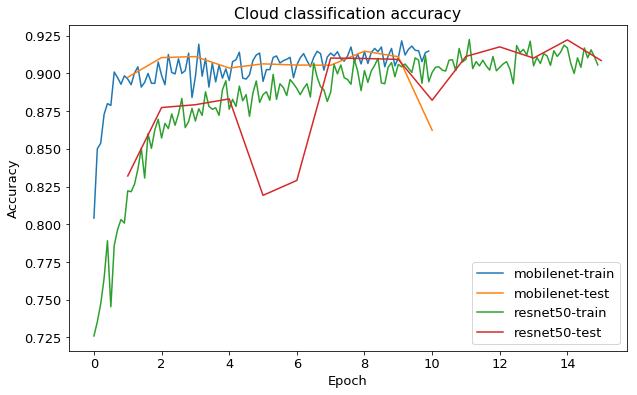

In [17]:
x = np.linspace(0, 20, 201)
plt.plot(x[:len(mobilenet_acc['train'])],          mobilenet_acc['train'], label='mobilenet-train')
plt.plot(x[::10][1:len(mobilenet_acc['valid'])+1], mobilenet_acc['valid'], label='mobilenet-validation')
plt.plot(x[:len(resnet_acc['train'])],          resnet_acc['train'], label='resnet50-train')
plt.plot(x[::10][1:len(resnet_acc['valid'])+1], resnet_acc['valid'], label='resnet50-validation')
plt.title('Cloud classification accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams.update({'font.size': 13})
plt.show()

Best test accuracy is obtained with ResNet50 after 14 epochs, so let us load the params of the network at that point.

In [15]:
rn50 = vision.resnet50_v2(classes=4)
rn50.load_params(os.path.join(checkpoints, '14-900.params'),ctx)

#### b) Confusion matrix

Utility functions to get predictions and generate the confusion matrix

In [10]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def get_predictions(data_iterator, net):
    preds = []
    labels= []

    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        data = color_normalize(data/255, mean, std)
        output = net(data)
        prediction = mx.nd.argmax(output, axis=1)
        preds.extend(prediction)
        labels.extend(label)
    
    preds = [j.asscalar() for i in preds for j in i]
    labels =[j.asscalar() for i in labels for j in i]
    
    return preds, labels

First, lets check the performance on the validation dataset

In [19]:
preds, labels = get_predictions(gluon.data.DataLoader(validIterator, 32), rn50)

Normalized confusion matrix
[[0.97621393 0.01674877 0.00548909 0.00154821]
 [0.24017467 0.65793304 0.04949054 0.05240175]
 [0.16141304 0.01576087 0.81847826 0.00434783]
 [0.10655738 0.08401639 0.1557377  0.65368852]]


array([[6936,  119,   39,   11],
       [ 165,  452,   34,   36],
       [ 297,   29, 1506,    8],
       [  52,   41,   76,  319]])

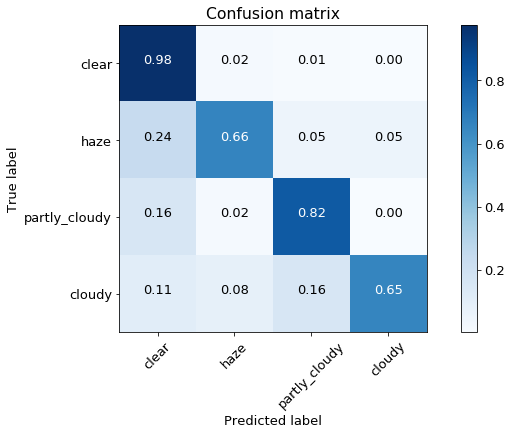

In [20]:
cm = confusion_matrix(labels, preds)
plot_confusion_matrix(cm, ['clear', 'haze', 'partly_cloudy', 'cloudy'], normalize=True)
cm

Our dataset is very imbalanced, and the network is too biased towards 'clear'. Lets try to find a solution to this problem.

####  Rebalancing classes

The main goal of this classifier is to identify those images which can safely be used for the segmentation system. This means distinguishing between clear and cloudy scenes, where *cloudy* can refer to any of the three non-clear classes in our dataset. Thus, let us try grouping those three classes into one to mitigate a bit the class imbalance.

First, load the new training and validation datasets, now with only two classes:

In [11]:
train_bin = os.path.join(DATA_DIR, 'train/clouds-binary.rec')
valid_bin = os.path.join(DATA_DIR, 'valid/clouds-binary.rec')

trainIterBin = ImageRecordDataset(
    filename=train_bin, 
    transform=lambda X, y: transform(X, y, train_augs)
)
validIterBin = ImageRecordDataset(
    filename=valid_bin, 
    transform=lambda X, y: transform(X, y, train_augs)
)

Load a new ResNet, as it was the best performing network from the previous case.

In [13]:
checkpoints = os.path.join(CHECKPOINTS_DIR, 'resnet50-binary')
os.makedirs(checkpoints, exist_ok=True)

# Load the pretrained network
rn50bin = vision.resnet50_v2(pretrained=True) 

We'll need a slightly modified version of the train utility function to deal with the binary case

In [14]:
def train_binary(net, ctx, batch_size=32, epochs=10, learning_rate=0.01, wd=0.001, momentum=0,
          checkpoint_dir='checkpoints', params=None, init_epoch=0):
    train_data = gluon.data.DataLoader(
        trainIterBin, batch_size, shuffle=True)
    
    valid_data = gluon.data.DataLoader(
        validIterBin, batch_size)
    
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params() if not params else params, 'adam', 
            {'learning_rate': learning_rate})
    
    return train_util(net, train_data, valid_data, 
               loss, trainer, ctx, epochs, batch_size,
               checkpoint_dir, init_epoch=init_epoch)

Train the network and save the results

In [15]:
rn50bin_acc = train_binary(rn50bin, ctx, batch_size=32, epochs=30, learning_rate=0.003,checkpoint_dir=checkpoints)

# Save
np.save(checkpoints + '/accuracy-results.npy', rn50bin_acc)

[Epoch 1 Batch 0] speed: 222.721805 samples/s, training: accuracy=0.031250
[Epoch 1 Batch 5] speed: 617.581389 samples/s, training: accuracy=0.556250
[Epoch 1 Batch 10] speed: 624.625846 samples/s, training: accuracy=0.646875
[Epoch 1 Batch 15] speed: 634.320266 samples/s, training: accuracy=0.689583
[Epoch 1 Batch 20] speed: 616.036535 samples/s, training: accuracy=0.712500
[Epoch 1 Batch 25] speed: 611.150094 samples/s, training: accuracy=0.721250
[Epoch 1 Batch 30] speed: 622.747839 samples/s, training: accuracy=0.714583
[Epoch 1 Batch 35] speed: 605.853378 samples/s, training: accuracy=0.720536
[Epoch 1 Batch 40] speed: 630.035525 samples/s, training: accuracy=0.737500
[Epoch 1 Batch 45] speed: 633.323556 samples/s, training: accuracy=0.743056
[Epoch 1 Batch 50] speed: 609.003752 samples/s, training: accuracy=0.746250
[Epoch 1 Batch 55] speed: 615.420756 samples/s, training: accuracy=0.755682
[Epoch 1 Batch 60] speed: 617.416614 samples/s, training: accuracy=0.757292
[Epoch 1 Batch

[Epoch 1 Batch 535] speed: 529.389578 samples/s, training: accuracy=0.849107
[Epoch 1 Batch 540] speed: 618.591843 samples/s, training: accuracy=0.845313
[Epoch 1 Batch 545] speed: 604.347521 samples/s, training: accuracy=0.840972
[Epoch 1 Batch 550] speed: 614.364377 samples/s, training: accuracy=0.842500
[Epoch 1 Batch 555] speed: 606.762693 samples/s, training: accuracy=0.838068
[Epoch 1 Batch 560] speed: 605.580021 samples/s, training: accuracy=0.833333
[Epoch 1 Batch 565] speed: 617.726349 samples/s, training: accuracy=0.836058
[Epoch 1 Batch 570] speed: 620.447699 samples/s, training: accuracy=0.838839
[Epoch 1 Batch 575] speed: 628.260146 samples/s, training: accuracy=0.841667
[Epoch 1 Batch 580] speed: 611.617967 samples/s, training: accuracy=0.841797
[Epoch 1 Batch 585] speed: 623.450767 samples/s, training: accuracy=0.842647
[Epoch 1 Batch 590] speed: 615.533650 samples/s, training: accuracy=0.843056
[Epoch 1 Batch 595] speed: 609.222132 samples/s, training: accuracy=0.838816

[Epoch 2 Batch 115] speed: 620.473513 samples/s, training: accuracy=0.889583
[Epoch 2 Batch 120] speed: 610.908085 samples/s, training: accuracy=0.876563
[Epoch 2 Batch 125] speed: 619.299702 samples/s, training: accuracy=0.876250
[Epoch 2 Batch 130] speed: 615.175352 samples/s, training: accuracy=0.877083
[Epoch 2 Batch 135] speed: 620.029233 samples/s, training: accuracy=0.874107
[Epoch 2 Batch 140] speed: 629.864039 samples/s, training: accuracy=0.874219
[Epoch 2 Batch 145] speed: 631.913182 samples/s, training: accuracy=0.868750
[Epoch 2 Batch 150] speed: 621.674817 samples/s, training: accuracy=0.867500
[Epoch 2 Batch 155] speed: 606.252921 samples/s, training: accuracy=0.867614
[Epoch 2 Batch 160] speed: 626.655623 samples/s, training: accuracy=0.866667
[Epoch 2 Batch 165] speed: 615.751090 samples/s, training: accuracy=0.865385
[Epoch 2 Batch 170] speed: 625.140792 samples/s, training: accuracy=0.866964
[Epoch 2 Batch 175] speed: 612.139597 samples/s, training: accuracy=0.866250

[Epoch 2 Batch 650] speed: 615.556234 samples/s, training: accuracy=0.875625
[Epoch 2 Batch 655] speed: 628.731030 samples/s, training: accuracy=0.877273
[Epoch 2 Batch 660] speed: 616.698882 samples/s, training: accuracy=0.876563
[Epoch 2 Batch 665] speed: 628.804670 samples/s, training: accuracy=0.877404
[Epoch 2 Batch 670] speed: 610.111087 samples/s, training: accuracy=0.879911
[Epoch 2 Batch 675] speed: 608.666815 samples/s, training: accuracy=0.874583
[Epoch 2 Batch 680] speed: 627.250129 samples/s, training: accuracy=0.876953
[Epoch 2 Batch 685] speed: 605.252319 samples/s, training: accuracy=0.879412
[Epoch 2 Batch 690] speed: 604.529898 samples/s, training: accuracy=0.879514
[Epoch 2 Batch 695] speed: 560.958469 samples/s, training: accuracy=0.878618
[Epoch 2 Batch 700] speed: 601.374322 samples/s, training: accuracy=0.879375
[Epoch 2 Batch 705] speed: 610.844137 samples/s, training: accuracy=0.837500
[Epoch 2 Batch 710] speed: 608.021600 samples/s, training: accuracy=0.881250

[Epoch 3 Batch 230] speed: 625.531203 samples/s, training: accuracy=0.890625
[Epoch 3 Batch 235] speed: 616.251500 samples/s, training: accuracy=0.891071
[Epoch 3 Batch 240] speed: 608.407461 samples/s, training: accuracy=0.894531
[Epoch 3 Batch 245] speed: 618.882783 samples/s, training: accuracy=0.894444
[Epoch 3 Batch 250] speed: 620.921303 samples/s, training: accuracy=0.893125
[Epoch 3 Batch 255] speed: 614.336257 samples/s, training: accuracy=0.896023
[Epoch 3 Batch 260] speed: 602.984550 samples/s, training: accuracy=0.894792
[Epoch 3 Batch 265] speed: 619.928999 samples/s, training: accuracy=0.895192
[Epoch 3 Batch 270] speed: 612.522319 samples/s, training: accuracy=0.898214
[Epoch 3 Batch 275] speed: 629.370797 samples/s, training: accuracy=0.898750
[Epoch 3 Batch 280] speed: 632.315079 samples/s, training: accuracy=0.901563
[Epoch 3 Batch 285] speed: 596.549749 samples/s, training: accuracy=0.901838
[Epoch 3 Batch 290] speed: 608.730307 samples/s, training: accuracy=0.898264

[Epoch 3 Batch 765] speed: 606.551555 samples/s, training: accuracy=0.906731
[Epoch 3 Batch 770] speed: 603.445425 samples/s, training: accuracy=0.907143
[Epoch 3 Batch 775] speed: 613.575171 samples/s, training: accuracy=0.907083
[Epoch 3 Batch 780] speed: 632.971119 samples/s, training: accuracy=0.905859
[Epoch 3 Batch 785] speed: 600.268914 samples/s, training: accuracy=0.905147
[Epoch 3 Batch 790] speed: 590.289776 samples/s, training: accuracy=0.904514
[Epoch 3 Batch 795] speed: 604.206051 samples/s, training: accuracy=0.905263
[Epoch 3 Batch 800] speed: 616.339227 samples/s, training: accuracy=0.904062
[Epoch 3 Batch 805] speed: 609.329998 samples/s, training: accuracy=0.906250
[Epoch 3 Batch 810] speed: 612.284807 samples/s, training: accuracy=0.912500
[Epoch 3 Batch 815] speed: 608.131796 samples/s, training: accuracy=0.897917
[Epoch 3 Batch 820] speed: 606.126981 samples/s, training: accuracy=0.890625
[Epoch 3 Batch 825] speed: 605.083145 samples/s, training: accuracy=0.890000

[Epoch 4 Batch 345] speed: 603.996688 samples/s, training: accuracy=0.913889
[Epoch 4 Batch 350] speed: 616.826420 samples/s, training: accuracy=0.913750
[Epoch 4 Batch 355] speed: 568.088512 samples/s, training: accuracy=0.917045
[Epoch 4 Batch 360] speed: 614.502204 samples/s, training: accuracy=0.917188
[Epoch 4 Batch 365] speed: 610.444074 samples/s, training: accuracy=0.917788
[Epoch 4 Batch 370] speed: 616.996552 samples/s, training: accuracy=0.920089
[Epoch 4 Batch 375] speed: 618.648869 samples/s, training: accuracy=0.920000
[Epoch 4 Batch 380] speed: 615.734141 samples/s, training: accuracy=0.921094
[Epoch 4 Batch 385] speed: 627.428993 samples/s, training: accuracy=0.918750
[Epoch 4 Batch 390] speed: 613.499447 samples/s, training: accuracy=0.917708
[Epoch 4 Batch 395] speed: 594.312393 samples/s, training: accuracy=0.919079
[Epoch 4 Batch 400] speed: 613.841758 samples/s, training: accuracy=0.917813
[Epoch 4 Batch 405] speed: 595.461990 samples/s, training: accuracy=0.912500

[Epoch 4 Batch 880] speed: 605.533575 samples/s, training: accuracy=0.900781
[Epoch 4 Batch 885] speed: 606.129718 samples/s, training: accuracy=0.899632
[Epoch 4 Batch 890] speed: 609.407464 samples/s, training: accuracy=0.899653
[Epoch 4 Batch 895] speed: 582.299597 samples/s, training: accuracy=0.899342
[Epoch 4 Batch 900] speed: 600.102514 samples/s, training: accuracy=0.900000
[Epoch 4 Batch 905] speed: 607.699505 samples/s, training: accuracy=0.900000
[Epoch 4 Batch 910] speed: 610.994296 samples/s, training: accuracy=0.871875
[Epoch 4 Batch 915] speed: 622.427276 samples/s, training: accuracy=0.889583
[Epoch 4 Batch 920] speed: 614.541595 samples/s, training: accuracy=0.903125
[Epoch 4 Batch 925] speed: 594.791731 samples/s, training: accuracy=0.901250
[Epoch 4 Batch 930] speed: 605.724869 samples/s, training: accuracy=0.888542
[Epoch 4 Batch 935] speed: 608.297165 samples/s, training: accuracy=0.883929
[Epoch 4 Batch 940] speed: 634.965455 samples/s, training: accuracy=0.887500

[Epoch 5 Batch 460] speed: 593.099077 samples/s, training: accuracy=0.915104
[Epoch 5 Batch 465] speed: 619.582728 samples/s, training: accuracy=0.918269
[Epoch 5 Batch 470] speed: 608.680616 samples/s, training: accuracy=0.917411
[Epoch 5 Batch 475] speed: 602.887043 samples/s, training: accuracy=0.917917
[Epoch 5 Batch 480] speed: 614.611948 samples/s, training: accuracy=0.914844
[Epoch 5 Batch 485] speed: 607.135972 samples/s, training: accuracy=0.915809
[Epoch 5 Batch 490] speed: 612.485981 samples/s, training: accuracy=0.916667
[Epoch 5 Batch 495] speed: 616.163799 samples/s, training: accuracy=0.915461
[Epoch 5 Batch 500] speed: 600.459582 samples/s, training: accuracy=0.915937
[Epoch 5 Batch 505] speed: 615.519536 samples/s, training: accuracy=0.931250
[Epoch 5 Batch 510] speed: 609.850502 samples/s, training: accuracy=0.937500
[Epoch 5 Batch 515] speed: 608.528833 samples/s, training: accuracy=0.937500
[Epoch 5 Batch 520] speed: 579.013857 samples/s, training: accuracy=0.934375

[Epoch 6 Batch 40] speed: 590.825056 samples/s, training: accuracy=0.925781
[Epoch 6 Batch 45] speed: 609.208306 samples/s, training: accuracy=0.916667
[Epoch 6 Batch 50] speed: 601.476731 samples/s, training: accuracy=0.915625
[Epoch 6 Batch 55] speed: 613.586391 samples/s, training: accuracy=0.916477
[Epoch 6 Batch 60] speed: 604.244133 samples/s, training: accuracy=0.917708
[Epoch 6 Batch 65] speed: 601.827341 samples/s, training: accuracy=0.917788
[Epoch 6 Batch 70] speed: 607.762796 samples/s, training: accuracy=0.918750
[Epoch 6 Batch 75] speed: 613.387297 samples/s, training: accuracy=0.919583
[Epoch 6 Batch 80] speed: 625.379642 samples/s, training: accuracy=0.919141
[Epoch 6 Batch 85] speed: 609.570759 samples/s, training: accuracy=0.918382
[Epoch 6 Batch 90] speed: 606.033928 samples/s, training: accuracy=0.919444
[Epoch 6 Batch 95] speed: 617.595597 samples/s, training: accuracy=0.919737
[Epoch 6 Batch 100] speed: 615.460264 samples/s, training: accuracy=0.918750
[Epoch 6 Ba

[Epoch 6 Batch 575] speed: 590.793848 samples/s, training: accuracy=0.916250
[Epoch 6 Batch 580] speed: 609.565222 samples/s, training: accuracy=0.918750
[Epoch 6 Batch 585] speed: 601.463254 samples/s, training: accuracy=0.918750
[Epoch 6 Batch 590] speed: 615.212009 samples/s, training: accuracy=0.920833
[Epoch 6 Batch 595] speed: 634.359240 samples/s, training: accuracy=0.920724
[Epoch 6 Batch 600] speed: 619.008371 samples/s, training: accuracy=0.919375
[Epoch 6 Batch 605] speed: 550.887699 samples/s, training: accuracy=0.912500
[Epoch 6 Batch 610] speed: 612.916715 samples/s, training: accuracy=0.931250
[Epoch 6 Batch 615] speed: 607.586715 samples/s, training: accuracy=0.925000
[Epoch 6 Batch 620] speed: 615.200730 samples/s, training: accuracy=0.920312
[Epoch 6 Batch 625] speed: 593.999398 samples/s, training: accuracy=0.918750
[Epoch 6 Batch 630] speed: 596.600131 samples/s, training: accuracy=0.917708
[Epoch 6 Batch 635] speed: 609.803398 samples/s, training: accuracy=0.916964

[Epoch 7 Batch 155] speed: 630.974440 samples/s, training: accuracy=0.910795
[Epoch 7 Batch 160] speed: 610.791321 samples/s, training: accuracy=0.909896
[Epoch 7 Batch 165] speed: 618.130324 samples/s, training: accuracy=0.909615
[Epoch 7 Batch 170] speed: 628.701580 samples/s, training: accuracy=0.912946
[Epoch 7 Batch 175] speed: 613.011893 samples/s, training: accuracy=0.911250
[Epoch 7 Batch 180] speed: 606.699610 samples/s, training: accuracy=0.910937
[Epoch 7 Batch 185] speed: 605.053140 samples/s, training: accuracy=0.909926
[Epoch 7 Batch 190] speed: 583.410755 samples/s, training: accuracy=0.910764
[Epoch 7 Batch 195] speed: 624.117553 samples/s, training: accuracy=0.911513
[Epoch 7 Batch 200] speed: 614.038338 samples/s, training: accuracy=0.911563
[Epoch 7 Batch 205] speed: 592.321700 samples/s, training: accuracy=0.937500
[Epoch 7 Batch 210] speed: 613.460190 samples/s, training: accuracy=0.925000
[Epoch 7 Batch 215] speed: 610.446850 samples/s, training: accuracy=0.914583

[Epoch 7 Batch 690] speed: 604.094554 samples/s, training: accuracy=0.928819
[Epoch 7 Batch 695] speed: 626.079766 samples/s, training: accuracy=0.926974
[Epoch 7 Batch 700] speed: 608.106998 samples/s, training: accuracy=0.925937
[Epoch 7 Batch 705] speed: 616.826420 samples/s, training: accuracy=0.931250
[Epoch 7 Batch 710] speed: 613.404117 samples/s, training: accuracy=0.912500
[Epoch 7 Batch 715] speed: 604.679693 samples/s, training: accuracy=0.910417
[Epoch 7 Batch 720] speed: 614.521899 samples/s, training: accuracy=0.917188
[Epoch 7 Batch 725] speed: 607.985794 samples/s, training: accuracy=0.921250
[Epoch 7 Batch 730] speed: 616.282626 samples/s, training: accuracy=0.918750
[Epoch 7 Batch 735] speed: 622.519656 samples/s, training: accuracy=0.918750
[Epoch 7 Batch 740] speed: 598.483602 samples/s, training: accuracy=0.919531
[Epoch 7 Batch 745] speed: 600.408546 samples/s, training: accuracy=0.920833
[Epoch 7 Batch 750] speed: 601.581871 samples/s, training: accuracy=0.924375

[Epoch 8 Batch 270] speed: 627.176853 samples/s, training: accuracy=0.921429
[Epoch 8 Batch 275] speed: 621.243192 samples/s, training: accuracy=0.921250
[Epoch 8 Batch 280] speed: 607.751787 samples/s, training: accuracy=0.921875
[Epoch 8 Batch 285] speed: 631.776356 samples/s, training: accuracy=0.922794
[Epoch 8 Batch 290] speed: 618.791478 samples/s, training: accuracy=0.924653
[Epoch 8 Batch 295] speed: 614.721731 samples/s, training: accuracy=0.925329
[Epoch 8 Batch 300] speed: 604.418281 samples/s, training: accuracy=0.925625
[Epoch 8 Batch 305] speed: 620.161017 samples/s, training: accuracy=0.912500
[Epoch 8 Batch 310] speed: 585.755743 samples/s, training: accuracy=0.896875
[Epoch 8 Batch 315] speed: 613.395707 samples/s, training: accuracy=0.912500
[Epoch 8 Batch 320] speed: 619.662822 samples/s, training: accuracy=0.921875
[Epoch 8 Batch 325] speed: 606.228277 samples/s, training: accuracy=0.921250
[Epoch 8 Batch 330] speed: 607.655484 samples/s, training: accuracy=0.919792

[Epoch 8 Batch 805] speed: 613.533100 samples/s, training: accuracy=0.956250
[Epoch 8 Batch 810] speed: 605.798687 samples/s, training: accuracy=0.956250
[Epoch 8 Batch 815] speed: 618.406583 samples/s, training: accuracy=0.952083
[Epoch 8 Batch 820] speed: 626.237510 samples/s, training: accuracy=0.942187
[Epoch 8 Batch 825] speed: 615.071045 samples/s, training: accuracy=0.942500
[Epoch 8 Batch 830] speed: 612.670507 samples/s, training: accuracy=0.941667
[Epoch 8 Batch 835] speed: 589.235053 samples/s, training: accuracy=0.941071
[Epoch 8 Batch 840] speed: 610.535708 samples/s, training: accuracy=0.938281
[Epoch 8 Batch 845] speed: 600.599303 samples/s, training: accuracy=0.936111
[Epoch 8 Batch 850] speed: 606.872433 samples/s, training: accuracy=0.934375
[Epoch 8 Batch 855] speed: 619.971953 samples/s, training: accuracy=0.931250
[Epoch 8 Batch 860] speed: 617.501831 samples/s, training: accuracy=0.931250
[Epoch 8 Batch 865] speed: 600.631555 samples/s, training: accuracy=0.930769

[Epoch 9 Batch 385] speed: 577.750206 samples/s, training: accuracy=0.916912
[Epoch 9 Batch 390] speed: 600.306501 samples/s, training: accuracy=0.919097
[Epoch 9 Batch 395] speed: 609.299571 samples/s, training: accuracy=0.917434
[Epoch 9 Batch 400] speed: 609.446204 samples/s, training: accuracy=0.917813
[Epoch 9 Batch 405] speed: 624.931220 samples/s, training: accuracy=0.931250
[Epoch 9 Batch 410] speed: 612.712460 samples/s, training: accuracy=0.912500
[Epoch 9 Batch 415] speed: 606.705095 samples/s, training: accuracy=0.918750
[Epoch 9 Batch 420] speed: 592.975922 samples/s, training: accuracy=0.920312
[Epoch 9 Batch 425] speed: 603.784754 samples/s, training: accuracy=0.925000
[Epoch 9 Batch 430] speed: 609.025860 samples/s, training: accuracy=0.931250
[Epoch 9 Batch 435] speed: 620.817910 samples/s, training: accuracy=0.933036
[Epoch 9 Batch 440] speed: 605.949111 samples/s, training: accuracy=0.928906
[Epoch 9 Batch 445] speed: 612.452443 samples/s, training: accuracy=0.928472

[Epoch 9 Batch 920] speed: 605.875257 samples/s, training: accuracy=0.923438
[Epoch 9 Batch 925] speed: 610.780203 samples/s, training: accuracy=0.922500
[Epoch 9 Batch 930] speed: 624.742144 samples/s, training: accuracy=0.918750
[Epoch 9 Batch 935] speed: 617.680864 samples/s, training: accuracy=0.922321
[Epoch 9 Batch 940] speed: 612.843951 samples/s, training: accuracy=0.925000
[Epoch 9 Batch 945] speed: 618.862808 samples/s, training: accuracy=0.929167
Epoch 9 | training_acc [0.927916120576671] | val_acc 0.9395256916996048 
[Epoch 10 Batch 0] speed: 582.858443 samples/s, training: accuracy=0.875000
[Epoch 10 Batch 5] speed: 618.138865 samples/s, training: accuracy=0.925000
[Epoch 10 Batch 10] speed: 614.437502 samples/s, training: accuracy=0.912500
[Epoch 10 Batch 15] speed: 620.952903 samples/s, training: accuracy=0.916667
[Epoch 10 Batch 20] speed: 592.863293 samples/s, training: accuracy=0.918750
[Epoch 10 Batch 25] speed: 585.599846 samples/s, training: accuracy=0.921250
[Epoc

[Epoch 10 Batch 495] speed: 608.341279 samples/s, training: accuracy=0.930921
[Epoch 10 Batch 500] speed: 610.258111 samples/s, training: accuracy=0.928438
[Epoch 10 Batch 505] speed: 609.462808 samples/s, training: accuracy=0.950000
[Epoch 10 Batch 510] speed: 579.376273 samples/s, training: accuracy=0.915625
[Epoch 10 Batch 515] speed: 606.072240 samples/s, training: accuracy=0.920833
[Epoch 10 Batch 520] speed: 616.693215 samples/s, training: accuracy=0.920312
[Epoch 10 Batch 525] speed: 609.130891 samples/s, training: accuracy=0.913750
[Epoch 10 Batch 530] speed: 614.856902 samples/s, training: accuracy=0.918750
[Epoch 10 Batch 535] speed: 610.577370 samples/s, training: accuracy=0.919643
[Epoch 10 Batch 540] speed: 614.024292 samples/s, training: accuracy=0.922656
[Epoch 10 Batch 545] speed: 618.281239 samples/s, training: accuracy=0.925000
[Epoch 10 Batch 550] speed: 608.683377 samples/s, training: accuracy=0.924375
[Epoch 10 Batch 555] speed: 619.385440 samples/s, training: accu

[Epoch 11 Batch 70] speed: 612.301567 samples/s, training: accuracy=0.923214
[Epoch 11 Batch 75] speed: 637.268786 samples/s, training: accuracy=0.925000
[Epoch 11 Batch 80] speed: 634.230344 samples/s, training: accuracy=0.925781
[Epoch 11 Batch 85] speed: 624.617126 samples/s, training: accuracy=0.927941
[Epoch 11 Batch 90] speed: 610.874719 samples/s, training: accuracy=0.927431
[Epoch 11 Batch 95] speed: 601.207308 samples/s, training: accuracy=0.930263
[Epoch 11 Batch 100] speed: 617.737722 samples/s, training: accuracy=0.931875
[Epoch 11 Batch 105] speed: 609.772924 samples/s, training: accuracy=0.937500
[Epoch 11 Batch 110] speed: 610.330262 samples/s, training: accuracy=0.931250
[Epoch 11 Batch 115] speed: 606.012037 samples/s, training: accuracy=0.929167
[Epoch 11 Batch 120] speed: 613.221951 samples/s, training: accuracy=0.935937
[Epoch 11 Batch 125] speed: 608.802097 samples/s, training: accuracy=0.936250
[Epoch 11 Batch 130] speed: 615.929109 samples/s, training: accuracy=0

[Epoch 11 Batch 600] speed: 607.281566 samples/s, training: accuracy=0.934063
[Epoch 11 Batch 605] speed: 603.866249 samples/s, training: accuracy=0.893750
[Epoch 11 Batch 610] speed: 609.155773 samples/s, training: accuracy=0.909375
[Epoch 11 Batch 615] speed: 608.788290 samples/s, training: accuracy=0.908333
[Epoch 11 Batch 620] speed: 630.112429 samples/s, training: accuracy=0.912500
[Epoch 11 Batch 625] speed: 596.507329 samples/s, training: accuracy=0.916250
[Epoch 11 Batch 630] speed: 616.163799 samples/s, training: accuracy=0.918750
[Epoch 11 Batch 635] speed: 610.077809 samples/s, training: accuracy=0.920536
[Epoch 11 Batch 640] speed: 605.992884 samples/s, training: accuracy=0.925000
[Epoch 11 Batch 645] speed: 604.916792 samples/s, training: accuracy=0.930556
[Epoch 11 Batch 650] speed: 612.692881 samples/s, training: accuracy=0.934375
[Epoch 11 Batch 655] speed: 611.980503 samples/s, training: accuracy=0.934659
[Epoch 11 Batch 660] speed: 614.454380 samples/s, training: accu

[Epoch 12 Batch 175] speed: 608.592297 samples/s, training: accuracy=0.937917
[Epoch 12 Batch 180] speed: 617.908357 samples/s, training: accuracy=0.939063
[Epoch 12 Batch 185] speed: 611.202973 samples/s, training: accuracy=0.937500
[Epoch 12 Batch 190] speed: 614.013056 samples/s, training: accuracy=0.935069
[Epoch 12 Batch 195] speed: 599.558333 samples/s, training: accuracy=0.933553
[Epoch 12 Batch 200] speed: 601.301579 samples/s, training: accuracy=0.933438
[Epoch 12 Batch 205] speed: 604.203331 samples/s, training: accuracy=0.906250
[Epoch 12 Batch 210] speed: 614.302515 samples/s, training: accuracy=0.931250
[Epoch 12 Batch 215] speed: 632.395520 samples/s, training: accuracy=0.929167
[Epoch 12 Batch 220] speed: 609.177891 samples/s, training: accuracy=0.934375
[Epoch 12 Batch 225] speed: 625.644921 samples/s, training: accuracy=0.932500
[Epoch 12 Batch 230] speed: 624.875940 samples/s, training: accuracy=0.933333
[Epoch 12 Batch 235] speed: 608.120774 samples/s, training: accu

[Epoch 12 Batch 705] speed: 613.808071 samples/s, training: accuracy=0.900000
[Epoch 12 Batch 710] speed: 613.294804 samples/s, training: accuracy=0.912500
[Epoch 12 Batch 715] speed: 614.330633 samples/s, training: accuracy=0.914583
[Epoch 12 Batch 720] speed: 602.210782 samples/s, training: accuracy=0.920312
[Epoch 12 Batch 725] speed: 614.462819 samples/s, training: accuracy=0.921250
[Epoch 12 Batch 730] speed: 591.202414 samples/s, training: accuracy=0.919792
[Epoch 12 Batch 735] speed: 605.588218 samples/s, training: accuracy=0.916964
[Epoch 12 Batch 740] speed: 606.146142 samples/s, training: accuracy=0.920312
[Epoch 12 Batch 745] speed: 620.312925 samples/s, training: accuracy=0.925694
[Epoch 12 Batch 750] speed: 613.791229 samples/s, training: accuracy=0.924375
[Epoch 12 Batch 755] speed: 600.712202 samples/s, training: accuracy=0.923295
[Epoch 12 Batch 760] speed: 613.895103 samples/s, training: accuracy=0.924479
[Epoch 12 Batch 765] speed: 618.808596 samples/s, training: accu

[Epoch 13 Batch 280] speed: 622.808523 samples/s, training: accuracy=0.928516
[Epoch 13 Batch 285] speed: 617.320063 samples/s, training: accuracy=0.929412
[Epoch 13 Batch 290] speed: 630.861741 samples/s, training: accuracy=0.926389
[Epoch 13 Batch 295] speed: 607.479465 samples/s, training: accuracy=0.927961
[Epoch 13 Batch 300] speed: 550.424567 samples/s, training: accuracy=0.930000
[Epoch 13 Batch 305] speed: 609.476646 samples/s, training: accuracy=0.918750
[Epoch 13 Batch 310] speed: 597.489841 samples/s, training: accuracy=0.918750
[Epoch 13 Batch 315] speed: 602.332397 samples/s, training: accuracy=0.912500
[Epoch 13 Batch 320] speed: 590.393638 samples/s, training: accuracy=0.909375
[Epoch 13 Batch 325] speed: 617.868534 samples/s, training: accuracy=0.911250
[Epoch 13 Batch 330] speed: 616.732887 samples/s, training: accuracy=0.913542
[Epoch 13 Batch 335] speed: 623.757891 samples/s, training: accuracy=0.909821
[Epoch 13 Batch 340] speed: 617.550131 samples/s, training: accu

[Epoch 13 Batch 810] speed: 611.022111 samples/s, training: accuracy=0.937500
[Epoch 13 Batch 815] speed: 631.871533 samples/s, training: accuracy=0.925000
[Epoch 13 Batch 820] speed: 604.235972 samples/s, training: accuracy=0.926562
[Epoch 13 Batch 825] speed: 622.225288 samples/s, training: accuracy=0.920000
[Epoch 13 Batch 830] speed: 608.918102 samples/s, training: accuracy=0.922917
[Epoch 13 Batch 835] speed: 607.078304 samples/s, training: accuracy=0.924107
[Epoch 13 Batch 840] speed: 619.199705 samples/s, training: accuracy=0.927344
[Epoch 13 Batch 845] speed: 624.535746 samples/s, training: accuracy=0.926389
[Epoch 13 Batch 850] speed: 598.024943 samples/s, training: accuracy=0.926250
[Epoch 13 Batch 855] speed: 605.001321 samples/s, training: accuracy=0.927841
[Epoch 13 Batch 860] speed: 605.867052 samples/s, training: accuracy=0.931250
[Epoch 13 Batch 865] speed: 612.813171 samples/s, training: accuracy=0.932692
[Epoch 13 Batch 870] speed: 612.547478 samples/s, training: accu

[Epoch 14 Batch 385] speed: 626.377793 samples/s, training: accuracy=0.940074
[Epoch 14 Batch 390] speed: 626.541537 samples/s, training: accuracy=0.940625
[Epoch 14 Batch 395] speed: 601.013474 samples/s, training: accuracy=0.940789
[Epoch 14 Batch 400] speed: 622.597624 samples/s, training: accuracy=0.940937
[Epoch 14 Batch 405] speed: 612.701272 samples/s, training: accuracy=0.912500
[Epoch 14 Batch 410] speed: 591.538537 samples/s, training: accuracy=0.915625
[Epoch 14 Batch 415] speed: 585.806875 samples/s, training: accuracy=0.925000
[Epoch 14 Batch 420] speed: 617.877067 samples/s, training: accuracy=0.931250
[Epoch 14 Batch 425] speed: 606.266614 samples/s, training: accuracy=0.926250
[Epoch 14 Batch 430] speed: 594.847089 samples/s, training: accuracy=0.923958
[Epoch 14 Batch 435] speed: 600.188386 samples/s, training: accuracy=0.923214
[Epoch 14 Batch 440] speed: 618.976969 samples/s, training: accuracy=0.928125
[Epoch 14 Batch 445] speed: 616.245841 samples/s, training: accu

[Epoch 14 Batch 915] speed: 618.338208 samples/s, training: accuracy=0.931250
[Epoch 14 Batch 920] speed: 612.846749 samples/s, training: accuracy=0.931250
[Epoch 14 Batch 925] speed: 609.299571 samples/s, training: accuracy=0.938750
[Epoch 14 Batch 930] speed: 611.175141 samples/s, training: accuracy=0.939583
[Epoch 14 Batch 935] speed: 608.650254 samples/s, training: accuracy=0.941964
[Epoch 14 Batch 940] speed: 611.333816 samples/s, training: accuracy=0.942969
[Epoch 14 Batch 945] speed: 611.202973 samples/s, training: accuracy=0.944444
Epoch 14 | training_acc [0.9442988204456094] | val_acc 0.941699604743083 
[Epoch 15 Batch 0] speed: 583.562951 samples/s, training: accuracy=0.875000
[Epoch 15 Batch 5] speed: 567.006155 samples/s, training: accuracy=0.956250
[Epoch 15 Batch 10] speed: 592.483813 samples/s, training: accuracy=0.953125
[Epoch 15 Batch 15] speed: 608.821428 samples/s, training: accuracy=0.958333
[Epoch 15 Batch 20] speed: 576.920750 samples/s, training: accuracy=0.9515

[Epoch 15 Batch 490] speed: 607.092033 samples/s, training: accuracy=0.930208
[Epoch 15 Batch 495] speed: 613.577976 samples/s, training: accuracy=0.929934
[Epoch 15 Batch 500] speed: 600.975798 samples/s, training: accuracy=0.930000
[Epoch 15 Batch 505] speed: 621.254695 samples/s, training: accuracy=0.918750
[Epoch 15 Batch 510] speed: 611.002640 samples/s, training: accuracy=0.928125
[Epoch 15 Batch 515] speed: 619.379724 samples/s, training: accuracy=0.941667
[Epoch 15 Batch 520] speed: 618.554782 samples/s, training: accuracy=0.939063
[Epoch 15 Batch 525] speed: 590.069190 samples/s, training: accuracy=0.937500
[Epoch 15 Batch 530] speed: 602.567659 samples/s, training: accuracy=0.942708
[Epoch 15 Batch 535] speed: 623.219175 samples/s, training: accuracy=0.943750
[Epoch 15 Batch 540] speed: 622.941492 samples/s, training: accuracy=0.940625
[Epoch 15 Batch 545] speed: 617.683707 samples/s, training: accuracy=0.937500
[Epoch 15 Batch 550] speed: 608.043636 samples/s, training: accu

[Epoch 16 Batch 65] speed: 603.372180 samples/s, training: accuracy=0.929808
[Epoch 16 Batch 70] speed: 596.284722 samples/s, training: accuracy=0.932143
[Epoch 16 Batch 75] speed: 623.077410 samples/s, training: accuracy=0.932500
[Epoch 16 Batch 80] speed: 618.777214 samples/s, training: accuracy=0.932422
[Epoch 16 Batch 85] speed: 609.997400 samples/s, training: accuracy=0.931250
[Epoch 16 Batch 90] speed: 616.076123 samples/s, training: accuracy=0.933333
[Epoch 16 Batch 95] speed: 610.713503 samples/s, training: accuracy=0.934868
[Epoch 16 Batch 100] speed: 600.354834 samples/s, training: accuracy=0.935625
[Epoch 16 Batch 105] speed: 630.426153 samples/s, training: accuracy=0.912500
[Epoch 16 Batch 110] speed: 610.480169 samples/s, training: accuracy=0.928125
[Epoch 16 Batch 115] speed: 617.575705 samples/s, training: accuracy=0.916667
[Epoch 16 Batch 120] speed: 621.338098 samples/s, training: accuracy=0.920312
[Epoch 16 Batch 125] speed: 617.888445 samples/s, training: accuracy=0.

[Epoch 16 Batch 595] speed: 615.290978 samples/s, training: accuracy=0.939145
[Epoch 16 Batch 600] speed: 568.948212 samples/s, training: accuracy=0.939375
[Epoch 16 Batch 605] speed: 605.170449 samples/s, training: accuracy=0.950000
[Epoch 16 Batch 610] speed: 602.667768 samples/s, training: accuracy=0.925000
[Epoch 16 Batch 615] speed: 572.542607 samples/s, training: accuracy=0.933333
[Epoch 16 Batch 620] speed: 617.672336 samples/s, training: accuracy=0.939063
[Epoch 16 Batch 625] speed: 611.239158 samples/s, training: accuracy=0.936250
[Epoch 16 Batch 630] speed: 609.977995 samples/s, training: accuracy=0.937500
[Epoch 16 Batch 635] speed: 624.071122 samples/s, training: accuracy=0.938393
[Epoch 16 Batch 640] speed: 619.008371 samples/s, training: accuracy=0.934375
[Epoch 16 Batch 645] speed: 618.728722 samples/s, training: accuracy=0.935417
[Epoch 16 Batch 650] speed: 606.614607 samples/s, training: accuracy=0.936250
[Epoch 16 Batch 655] speed: 619.299702 samples/s, training: accu

[Epoch 17 Batch 170] speed: 594.444003 samples/s, training: accuracy=0.939732
[Epoch 17 Batch 175] speed: 600.132029 samples/s, training: accuracy=0.939583
[Epoch 17 Batch 180] speed: 619.949043 samples/s, training: accuracy=0.940625
[Epoch 17 Batch 185] speed: 618.141712 samples/s, training: accuracy=0.941176
[Epoch 17 Batch 190] speed: 626.556161 samples/s, training: accuracy=0.938889
[Epoch 17 Batch 195] speed: 608.625414 samples/s, training: accuracy=0.939803
[Epoch 17 Batch 200] speed: 594.307130 samples/s, training: accuracy=0.940000
[Epoch 17 Batch 205] speed: 613.631276 samples/s, training: accuracy=0.918750
[Epoch 17 Batch 210] speed: 608.071183 samples/s, training: accuracy=0.931250
[Epoch 17 Batch 215] speed: 562.842727 samples/s, training: accuracy=0.935417
[Epoch 17 Batch 220] speed: 615.296619 samples/s, training: accuracy=0.929688
[Epoch 17 Batch 225] speed: 610.802439 samples/s, training: accuracy=0.927500
[Epoch 17 Batch 230] speed: 626.640994 samples/s, training: accu

[Epoch 17 Batch 700] speed: 624.506686 samples/s, training: accuracy=0.940000
[Epoch 17 Batch 705] speed: 558.600470 samples/s, training: accuracy=0.931250
[Epoch 17 Batch 710] speed: 612.620171 samples/s, training: accuracy=0.928125
[Epoch 17 Batch 715] speed: 608.208957 samples/s, training: accuracy=0.925000
[Epoch 17 Batch 720] speed: 613.429348 samples/s, training: accuracy=0.932813
[Epoch 17 Batch 725] speed: 618.198654 samples/s, training: accuracy=0.928750
[Epoch 17 Batch 730] speed: 616.902968 samples/s, training: accuracy=0.923958
[Epoch 17 Batch 735] speed: 601.161531 samples/s, training: accuracy=0.923214
[Epoch 17 Batch 740] speed: 615.926282 samples/s, training: accuracy=0.925000
[Epoch 17 Batch 745] speed: 613.799650 samples/s, training: accuracy=0.928472
[Epoch 17 Batch 750] speed: 566.137981 samples/s, training: accuracy=0.928125
[Epoch 17 Batch 755] speed: 616.914310 samples/s, training: accuracy=0.926705
[Epoch 17 Batch 760] speed: 592.078698 samples/s, training: accu

[Epoch 18 Batch 275] speed: 601.751790 samples/s, training: accuracy=0.930833
[Epoch 18 Batch 280] speed: 596.425157 samples/s, training: accuracy=0.932813
[Epoch 18 Batch 285] speed: 615.178172 samples/s, training: accuracy=0.932721
[Epoch 18 Batch 290] speed: 606.663961 samples/s, training: accuracy=0.930903
[Epoch 18 Batch 295] speed: 615.657883 samples/s, training: accuracy=0.931579
[Epoch 18 Batch 300] speed: 615.367145 samples/s, training: accuracy=0.932500
[Epoch 18 Batch 305] speed: 597.992969 samples/s, training: accuracy=0.925000
[Epoch 18 Batch 310] speed: 624.262695 samples/s, training: accuracy=0.918750
[Epoch 18 Batch 315] speed: 601.293497 samples/s, training: accuracy=0.920833
[Epoch 18 Batch 320] speed: 615.680476 samples/s, training: accuracy=0.926562
[Epoch 18 Batch 325] speed: 609.526467 samples/s, training: accuracy=0.930000
[Epoch 18 Batch 330] speed: 611.216890 samples/s, training: accuracy=0.930208
[Epoch 18 Batch 335] speed: 603.741298 samples/s, training: accu

[Epoch 18 Batch 805] speed: 603.027896 samples/s, training: accuracy=0.943750
[Epoch 18 Batch 810] speed: 617.209350 samples/s, training: accuracy=0.931250
[Epoch 18 Batch 815] speed: 618.623206 samples/s, training: accuracy=0.937500
[Epoch 18 Batch 820] speed: 588.798203 samples/s, training: accuracy=0.934375
[Epoch 18 Batch 825] speed: 593.429490 samples/s, training: accuracy=0.930000
[Epoch 18 Batch 830] speed: 629.190823 samples/s, training: accuracy=0.930208
[Epoch 18 Batch 835] speed: 609.795087 samples/s, training: accuracy=0.933036
[Epoch 18 Batch 840] speed: 615.522359 samples/s, training: accuracy=0.930469
[Epoch 18 Batch 845] speed: 605.645604 samples/s, training: accuracy=0.931944
[Epoch 18 Batch 850] speed: 605.864317 samples/s, training: accuracy=0.933750
[Epoch 18 Batch 855] speed: 597.109730 samples/s, training: accuracy=0.930114
[Epoch 18 Batch 860] speed: 620.950030 samples/s, training: accuracy=0.931250
[Epoch 18 Batch 865] speed: 612.930710 samples/s, training: accu

[Epoch 19 Batch 380] speed: 579.191259 samples/s, training: accuracy=0.931641
[Epoch 19 Batch 385] speed: 613.499447 samples/s, training: accuracy=0.931985
[Epoch 19 Batch 390] speed: 621.922553 samples/s, training: accuracy=0.934375
[Epoch 19 Batch 395] speed: 619.811624 samples/s, training: accuracy=0.933553
[Epoch 19 Batch 400] speed: 598.881498 samples/s, training: accuracy=0.933750
[Epoch 19 Batch 405] speed: 615.231749 samples/s, training: accuracy=0.906250
[Epoch 19 Batch 410] speed: 606.680414 samples/s, training: accuracy=0.915625
[Epoch 19 Batch 415] speed: 592.021243 samples/s, training: accuracy=0.922917
[Epoch 19 Batch 420] speed: 605.842439 samples/s, training: accuracy=0.928125
[Epoch 19 Batch 425] speed: 605.320561 samples/s, training: accuracy=0.930000
[Epoch 19 Batch 430] speed: 614.873803 samples/s, training: accuracy=0.931250
[Epoch 19 Batch 435] speed: 558.579548 samples/s, training: accuracy=0.931250
[Epoch 19 Batch 440] speed: 611.553871 samples/s, training: accu

[Epoch 19 Batch 910] speed: 613.645303 samples/s, training: accuracy=0.928125
[Epoch 19 Batch 915] speed: 614.738624 samples/s, training: accuracy=0.937500
[Epoch 19 Batch 920] speed: 604.026588 samples/s, training: accuracy=0.939063
[Epoch 19 Batch 925] speed: 604.255014 samples/s, training: accuracy=0.941250
[Epoch 19 Batch 930] speed: 578.410005 samples/s, training: accuracy=0.941667
[Epoch 19 Batch 935] speed: 615.753914 samples/s, training: accuracy=0.941964
[Epoch 19 Batch 940] speed: 609.814481 samples/s, training: accuracy=0.940625
[Epoch 19 Batch 945] speed: 618.380941 samples/s, training: accuracy=0.945139
Epoch 19 | training_acc [0.9456094364351245] | val_acc 0.9407114624505929 
[Epoch 20 Batch 0] speed: 580.787759 samples/s, training: accuracy=0.812500
[Epoch 20 Batch 5] speed: 615.415112 samples/s, training: accuracy=0.931250
[Epoch 20 Batch 10] speed: 619.814487 samples/s, training: accuracy=0.937500
[Epoch 20 Batch 15] speed: 611.475859 samples/s, training: accuracy=0.94

[Epoch 20 Batch 485] speed: 609.617826 samples/s, training: accuracy=0.936029
[Epoch 20 Batch 490] speed: 614.538781 samples/s, training: accuracy=0.936458
[Epoch 20 Batch 495] speed: 600.105197 samples/s, training: accuracy=0.936513
[Epoch 20 Batch 500] speed: 619.599889 samples/s, training: accuracy=0.937813
[Epoch 20 Batch 505] speed: 618.594694 samples/s, training: accuracy=0.937500
[Epoch 20 Batch 510] speed: 608.390914 samples/s, training: accuracy=0.950000
[Epoch 20 Batch 515] speed: 590.570287 samples/s, training: accuracy=0.945833
[Epoch 20 Batch 520] speed: 603.412870 samples/s, training: accuracy=0.935937
[Epoch 20 Batch 525] speed: 622.395526 samples/s, training: accuracy=0.932500
[Epoch 20 Batch 530] speed: 605.779547 samples/s, training: accuracy=0.931250
[Epoch 20 Batch 535] speed: 617.857157 samples/s, training: accuracy=0.931250
[Epoch 20 Batch 540] speed: 608.319221 samples/s, training: accuracy=0.932031
[Epoch 20 Batch 545] speed: 589.170389 samples/s, training: accu

[Epoch 21 Batch 60] speed: 613.025893 samples/s, training: accuracy=0.945833
[Epoch 21 Batch 65] speed: 610.988733 samples/s, training: accuracy=0.944712
[Epoch 21 Batch 70] speed: 617.709292 samples/s, training: accuracy=0.943304
[Epoch 21 Batch 75] speed: 600.008619 samples/s, training: accuracy=0.942917
[Epoch 21 Batch 80] speed: 594.731112 samples/s, training: accuracy=0.941016
[Epoch 21 Batch 85] speed: 594.646795 samples/s, training: accuracy=0.940441
[Epoch 21 Batch 90] speed: 606.058557 samples/s, training: accuracy=0.941319
[Epoch 21 Batch 95] speed: 595.160978 samples/s, training: accuracy=0.941447
[Epoch 21 Batch 100] speed: 594.818090 samples/s, training: accuracy=0.940312
[Epoch 21 Batch 105] speed: 609.498788 samples/s, training: accuracy=0.912500
[Epoch 21 Batch 110] speed: 618.643166 samples/s, training: accuracy=0.934375
[Epoch 21 Batch 115] speed: 612.511137 samples/s, training: accuracy=0.925000
[Epoch 21 Batch 120] speed: 613.123906 samples/s, training: accuracy=0.9

[Epoch 21 Batch 590] speed: 606.132455 samples/s, training: accuracy=0.934722
[Epoch 21 Batch 595] speed: 606.198158 samples/s, training: accuracy=0.934539
[Epoch 21 Batch 600] speed: 613.951265 samples/s, training: accuracy=0.933438
[Epoch 21 Batch 605] speed: 609.689826 samples/s, training: accuracy=0.918750
[Epoch 21 Batch 610] speed: 598.523635 samples/s, training: accuracy=0.915625
[Epoch 21 Batch 615] speed: 616.520418 samples/s, training: accuracy=0.922917
[Epoch 21 Batch 620] speed: 604.845915 samples/s, training: accuracy=0.923438
[Epoch 21 Batch 625] speed: 601.875919 samples/s, training: accuracy=0.925000
[Epoch 21 Batch 630] speed: 606.801098 samples/s, training: accuracy=0.926042
[Epoch 21 Batch 635] speed: 610.635705 samples/s, training: accuracy=0.925000
[Epoch 21 Batch 640] speed: 609.731372 samples/s, training: accuracy=0.928906
[Epoch 21 Batch 645] speed: 604.002124 samples/s, training: accuracy=0.929167
[Epoch 21 Batch 650] speed: 588.369738 samples/s, training: accu

[Epoch 22 Batch 165] speed: 612.595006 samples/s, training: accuracy=0.931731
[Epoch 22 Batch 170] speed: 617.197997 samples/s, training: accuracy=0.931696
[Epoch 22 Batch 175] speed: 610.835797 samples/s, training: accuracy=0.933750
[Epoch 22 Batch 180] speed: 607.163437 samples/s, training: accuracy=0.933594
[Epoch 22 Batch 185] speed: 600.669188 samples/s, training: accuracy=0.933824
[Epoch 22 Batch 190] speed: 612.064226 samples/s, training: accuracy=0.934722
[Epoch 22 Batch 195] speed: 608.098733 samples/s, training: accuracy=0.935855
[Epoch 22 Batch 200] speed: 617.882756 samples/s, training: accuracy=0.932813
[Epoch 22 Batch 205] speed: 614.803390 samples/s, training: accuracy=0.931250
[Epoch 22 Batch 210] speed: 612.455238 samples/s, training: accuracy=0.943750
[Epoch 22 Batch 215] speed: 614.628835 samples/s, training: accuracy=0.941667
[Epoch 22 Batch 220] speed: 608.261327 samples/s, training: accuracy=0.943750
[Epoch 22 Batch 225] speed: 625.097119 samples/s, training: accu

[Epoch 22 Batch 695] speed: 611.052711 samples/s, training: accuracy=0.947697
[Epoch 22 Batch 700] speed: 602.521674 samples/s, training: accuracy=0.946875
[Epoch 22 Batch 705] speed: 625.437926 samples/s, training: accuracy=0.962500
[Epoch 22 Batch 710] speed: 610.524600 samples/s, training: accuracy=0.953125
[Epoch 22 Batch 715] speed: 607.388745 samples/s, training: accuracy=0.954167
[Epoch 22 Batch 720] speed: 613.188332 samples/s, training: accuracy=0.951562
[Epoch 22 Batch 725] speed: 610.924769 samples/s, training: accuracy=0.947500
[Epoch 22 Batch 730] speed: 609.645517 samples/s, training: accuracy=0.950000
[Epoch 22 Batch 735] speed: 592.164902 samples/s, training: accuracy=0.947321
[Epoch 22 Batch 740] speed: 624.248178 samples/s, training: accuracy=0.946094
[Epoch 22 Batch 745] speed: 633.449095 samples/s, training: accuracy=0.944444
[Epoch 22 Batch 750] speed: 614.983679 samples/s, training: accuracy=0.941875
[Epoch 22 Batch 755] speed: 628.524932 samples/s, training: accu

[Epoch 23 Batch 270] speed: 606.296739 samples/s, training: accuracy=0.938839
[Epoch 23 Batch 275] speed: 587.093214 samples/s, training: accuracy=0.937917
[Epoch 23 Batch 280] speed: 608.882191 samples/s, training: accuracy=0.939453
[Epoch 23 Batch 285] speed: 619.094028 samples/s, training: accuracy=0.938971
[Epoch 23 Batch 290] speed: 616.690381 samples/s, training: accuracy=0.938194
[Epoch 23 Batch 295] speed: 612.189854 samples/s, training: accuracy=0.937829
[Epoch 23 Batch 300] speed: 609.133656 samples/s, training: accuracy=0.937813
[Epoch 23 Batch 305] speed: 602.254017 samples/s, training: accuracy=0.956250
[Epoch 23 Batch 310] speed: 608.305436 samples/s, training: accuracy=0.950000
[Epoch 23 Batch 315] speed: 610.610703 samples/s, training: accuracy=0.950000
[Epoch 23 Batch 320] speed: 594.928826 samples/s, training: accuracy=0.948438
[Epoch 23 Batch 325] speed: 607.001429 samples/s, training: accuracy=0.942500
[Epoch 23 Batch 330] speed: 628.742812 samples/s, training: accu

[Epoch 23 Batch 800] speed: 575.338011 samples/s, training: accuracy=0.938125
[Epoch 23 Batch 805] speed: 606.729779 samples/s, training: accuracy=0.906250
[Epoch 23 Batch 810] speed: 613.572366 samples/s, training: accuracy=0.925000
[Epoch 23 Batch 815] speed: 601.069996 samples/s, training: accuracy=0.933333
[Epoch 23 Batch 820] speed: 606.735264 samples/s, training: accuracy=0.935937
[Epoch 23 Batch 825] speed: 609.352129 samples/s, training: accuracy=0.935000
[Epoch 23 Batch 830] speed: 616.415654 samples/s, training: accuracy=0.928125
[Epoch 23 Batch 835] speed: 613.342448 samples/s, training: accuracy=0.933036
[Epoch 23 Batch 840] speed: 620.338729 samples/s, training: accuracy=0.932031
[Epoch 23 Batch 845] speed: 616.104403 samples/s, training: accuracy=0.929861
[Epoch 23 Batch 850] speed: 622.233942 samples/s, training: accuracy=0.931250
[Epoch 23 Batch 855] speed: 634.206369 samples/s, training: accuracy=0.932955
[Epoch 23 Batch 860] speed: 595.448781 samples/s, training: accu

[Epoch 24 Batch 375] speed: 607.402489 samples/s, training: accuracy=0.931667
[Epoch 24 Batch 380] speed: 613.521882 samples/s, training: accuracy=0.931641
[Epoch 24 Batch 385] speed: 614.747071 samples/s, training: accuracy=0.930882
[Epoch 24 Batch 390] speed: 586.188088 samples/s, training: accuracy=0.930208
[Epoch 24 Batch 395] speed: 617.121376 samples/s, training: accuracy=0.931908
[Epoch 24 Batch 400] speed: 620.169614 samples/s, training: accuracy=0.931875
[Epoch 24 Batch 405] speed: 604.178853 samples/s, training: accuracy=0.931250
[Epoch 24 Batch 410] speed: 620.817910 samples/s, training: accuracy=0.937500
[Epoch 24 Batch 415] speed: 590.679447 samples/s, training: accuracy=0.939583
[Epoch 24 Batch 420] speed: 600.833212 samples/s, training: accuracy=0.943750
[Epoch 24 Batch 425] speed: 616.025225 samples/s, training: accuracy=0.948750
[Epoch 24 Batch 430] speed: 567.557617 samples/s, training: accuracy=0.944792
[Epoch 24 Batch 435] speed: 614.831553 samples/s, training: accu

[Epoch 24 Batch 905] speed: 619.468343 samples/s, training: accuracy=0.950000
[Epoch 24 Batch 910] speed: 609.980767 samples/s, training: accuracy=0.953125
[Epoch 24 Batch 915] speed: 607.215628 samples/s, training: accuracy=0.935417
[Epoch 24 Batch 920] speed: 581.019065 samples/s, training: accuracy=0.943750
[Epoch 24 Batch 925] speed: 626.968843 samples/s, training: accuracy=0.945000
[Epoch 24 Batch 930] speed: 620.611226 samples/s, training: accuracy=0.943750
[Epoch 24 Batch 935] speed: 611.130615 samples/s, training: accuracy=0.943750
[Epoch 24 Batch 940] speed: 585.242364 samples/s, training: accuracy=0.941406
[Epoch 24 Batch 945] speed: 604.002124 samples/s, training: accuracy=0.943056
Epoch 24 | training_acc [0.9436435124508519] | val_acc 0.9455533596837945 
[Epoch 25 Batch 0] speed: 596.276774 samples/s, training: accuracy=0.906250
[Epoch 25 Batch 5] speed: 620.743258 samples/s, training: accuracy=0.943750
[Epoch 25 Batch 10] speed: 564.868031 samples/s, training: accuracy=0.9

[Epoch 25 Batch 480] speed: 618.600396 samples/s, training: accuracy=0.933594
[Epoch 25 Batch 485] speed: 621.879329 samples/s, training: accuracy=0.933456
[Epoch 25 Batch 490] speed: 615.909324 samples/s, training: accuracy=0.932292
[Epoch 25 Batch 495] speed: 613.959691 samples/s, training: accuracy=0.934211
[Epoch 25 Batch 500] speed: 613.224752 samples/s, training: accuracy=0.936562
[Epoch 25 Batch 505] speed: 592.005575 samples/s, training: accuracy=0.931250
[Epoch 25 Batch 510] speed: 614.220990 samples/s, training: accuracy=0.943750
[Epoch 25 Batch 515] speed: 614.502204 samples/s, training: accuracy=0.950000
[Epoch 25 Batch 520] speed: 581.154917 samples/s, training: accuracy=0.946875
[Epoch 25 Batch 525] speed: 569.510710 samples/s, training: accuracy=0.940000
[Epoch 25 Batch 530] speed: 619.777279 samples/s, training: accuracy=0.946875
[Epoch 25 Batch 535] speed: 607.754539 samples/s, training: accuracy=0.946429
[Epoch 25 Batch 540] speed: 603.079378 samples/s, training: accu

[Epoch 26 Batch 55] speed: 605.965525 samples/s, training: accuracy=0.938636
[Epoch 26 Batch 60] speed: 607.435476 samples/s, training: accuracy=0.939063
[Epoch 26 Batch 65] speed: 621.810183 samples/s, training: accuracy=0.938462
[Epoch 26 Batch 70] speed: 624.634567 samples/s, training: accuracy=0.939732
[Epoch 26 Batch 75] speed: 619.211131 samples/s, training: accuracy=0.938750
[Epoch 26 Batch 80] speed: 612.368614 samples/s, training: accuracy=0.938672
[Epoch 26 Batch 85] speed: 610.321936 samples/s, training: accuracy=0.939338
[Epoch 26 Batch 90] speed: 620.261326 samples/s, training: accuracy=0.938889
[Epoch 26 Batch 95] speed: 614.949867 samples/s, training: accuracy=0.939145
[Epoch 26 Batch 100] speed: 611.264212 samples/s, training: accuracy=0.939688
[Epoch 26 Batch 105] speed: 613.622859 samples/s, training: accuracy=0.931250
[Epoch 26 Batch 110] speed: 614.167588 samples/s, training: accuracy=0.950000
[Epoch 26 Batch 115] speed: 618.369544 samples/s, training: accuracy=0.94

[Epoch 26 Batch 585] speed: 612.751622 samples/s, training: accuracy=0.941544
[Epoch 26 Batch 590] speed: 598.443574 samples/s, training: accuracy=0.941319
[Epoch 26 Batch 595] speed: 587.075238 samples/s, training: accuracy=0.941118
[Epoch 26 Batch 600] speed: 613.693002 samples/s, training: accuracy=0.941250
[Epoch 26 Batch 605] speed: 614.693578 samples/s, training: accuracy=0.937500
[Epoch 26 Batch 610] speed: 601.121144 samples/s, training: accuracy=0.943750
[Epoch 26 Batch 615] speed: 622.127227 samples/s, training: accuracy=0.937500
[Epoch 26 Batch 620] speed: 614.257533 samples/s, training: accuracy=0.939063
[Epoch 26 Batch 625] speed: 579.511358 samples/s, training: accuracy=0.940000
[Epoch 26 Batch 630] speed: 599.740510 samples/s, training: accuracy=0.937500
[Epoch 26 Batch 635] speed: 608.989936 samples/s, training: accuracy=0.937500
[Epoch 26 Batch 640] speed: 609.117069 samples/s, training: accuracy=0.936719
[Epoch 26 Batch 645] speed: 623.856467 samples/s, training: accu

[Epoch 27 Batch 160] speed: 628.563197 samples/s, training: accuracy=0.939583
[Epoch 27 Batch 165] speed: 608.129040 samples/s, training: accuracy=0.938462
[Epoch 27 Batch 170] speed: 626.834149 samples/s, training: accuracy=0.938393
[Epoch 27 Batch 175] speed: 611.370017 samples/s, training: accuracy=0.938750
[Epoch 27 Batch 180] speed: 617.916891 samples/s, training: accuracy=0.939844
[Epoch 27 Batch 185] speed: 625.373814 samples/s, training: accuracy=0.937868
[Epoch 27 Batch 190] speed: 613.249969 samples/s, training: accuracy=0.938194
[Epoch 27 Batch 195] speed: 586.003816 samples/s, training: accuracy=0.938816
[Epoch 27 Batch 200] speed: 593.353410 samples/s, training: accuracy=0.939688
[Epoch 27 Batch 205] speed: 610.771865 samples/s, training: accuracy=0.918750
[Epoch 27 Batch 210] speed: 617.814496 samples/s, training: accuracy=0.925000
[Epoch 27 Batch 215] speed: 615.358681 samples/s, training: accuracy=0.922917
[Epoch 27 Batch 220] speed: 616.061984 samples/s, training: accu

[Epoch 27 Batch 690] speed: 612.897123 samples/s, training: accuracy=0.934375
[Epoch 27 Batch 695] speed: 595.385388 samples/s, training: accuracy=0.934868
[Epoch 27 Batch 700] speed: 543.950978 samples/s, training: accuracy=0.937187
[Epoch 27 Batch 705] speed: 603.442712 samples/s, training: accuracy=0.937500
[Epoch 27 Batch 710] speed: 607.793070 samples/s, training: accuracy=0.931250
[Epoch 27 Batch 715] speed: 607.473966 samples/s, training: accuracy=0.935417
[Epoch 27 Batch 720] speed: 598.745246 samples/s, training: accuracy=0.931250
[Epoch 27 Batch 725] speed: 612.421703 samples/s, training: accuracy=0.937500
[Epoch 27 Batch 730] speed: 611.947020 samples/s, training: accuracy=0.937500
[Epoch 27 Batch 735] speed: 606.211848 samples/s, training: accuracy=0.938393
[Epoch 27 Batch 740] speed: 615.833022 samples/s, training: accuracy=0.942187
[Epoch 27 Batch 745] speed: 608.288895 samples/s, training: accuracy=0.939583
[Epoch 27 Batch 750] speed: 604.246853 samples/s, training: accu

[Epoch 28 Batch 265] speed: 600.986562 samples/s, training: accuracy=0.939904
[Epoch 28 Batch 270] speed: 609.006516 samples/s, training: accuracy=0.940179
[Epoch 28 Batch 275] speed: 607.559211 samples/s, training: accuracy=0.940000
[Epoch 28 Batch 280] speed: 630.366936 samples/s, training: accuracy=0.942187
[Epoch 28 Batch 285] speed: 600.215226 samples/s, training: accuracy=0.942279
[Epoch 28 Batch 290] speed: 607.564712 samples/s, training: accuracy=0.942361
[Epoch 28 Batch 295] speed: 610.902523 samples/s, training: accuracy=0.941118
[Epoch 28 Batch 300] speed: 606.776408 samples/s, training: accuracy=0.940312
[Epoch 28 Batch 305] speed: 617.484786 samples/s, training: accuracy=0.931250
[Epoch 28 Batch 310] speed: 611.715531 samples/s, training: accuracy=0.950000
[Epoch 28 Batch 315] speed: 605.965525 samples/s, training: accuracy=0.945833
[Epoch 28 Batch 320] speed: 597.670763 samples/s, training: accuracy=0.948438
[Epoch 28 Batch 325] speed: 602.998095 samples/s, training: accu

[Epoch 28 Batch 795] speed: 615.688948 samples/s, training: accuracy=0.941118
[Epoch 28 Batch 800] speed: 606.993194 samples/s, training: accuracy=0.939688
[Epoch 28 Batch 805] speed: 620.774839 samples/s, training: accuracy=0.962500
[Epoch 28 Batch 810] speed: 616.520418 samples/s, training: accuracy=0.946875
[Epoch 28 Batch 815] speed: 633.834989 samples/s, training: accuracy=0.933333
[Epoch 28 Batch 820] speed: 611.269779 samples/s, training: accuracy=0.932813
[Epoch 28 Batch 825] speed: 631.553397 samples/s, training: accuracy=0.936250
[Epoch 28 Batch 830] speed: 611.331032 samples/s, training: accuracy=0.936458
[Epoch 28 Batch 835] speed: 600.301131 samples/s, training: accuracy=0.938393
[Epoch 28 Batch 840] speed: 576.866199 samples/s, training: accuracy=0.941406
[Epoch 28 Batch 845] speed: 614.690763 samples/s, training: accuracy=0.938194
[Epoch 28 Batch 850] speed: 618.346754 samples/s, training: accuracy=0.938125
[Epoch 28 Batch 855] speed: 590.666450 samples/s, training: accu

[Epoch 29 Batch 370] speed: 603.765741 samples/s, training: accuracy=0.943750
[Epoch 29 Batch 375] speed: 613.639692 samples/s, training: accuracy=0.942917
[Epoch 29 Batch 380] speed: 621.856278 samples/s, training: accuracy=0.944531
[Epoch 29 Batch 385] speed: 615.567527 samples/s, training: accuracy=0.944853
[Epoch 29 Batch 390] speed: 604.625213 samples/s, training: accuracy=0.943750
[Epoch 29 Batch 395] speed: 615.186631 samples/s, training: accuracy=0.941776
[Epoch 29 Batch 400] speed: 599.151514 samples/s, training: accuracy=0.942187
[Epoch 29 Batch 405] speed: 606.170780 samples/s, training: accuracy=0.931250
[Epoch 29 Batch 410] speed: 613.118304 samples/s, training: accuracy=0.934375
[Epoch 29 Batch 415] speed: 608.989936 samples/s, training: accuracy=0.931250
[Epoch 29 Batch 420] speed: 591.726308 samples/s, training: accuracy=0.939063
[Epoch 29 Batch 425] speed: 628.345441 samples/s, training: accuracy=0.942500
[Epoch 29 Batch 430] speed: 565.203430 samples/s, training: accu

[Epoch 29 Batch 900] speed: 607.490463 samples/s, training: accuracy=0.942187
[Epoch 29 Batch 905] speed: 618.207196 samples/s, training: accuracy=0.950000
[Epoch 29 Batch 910] speed: 578.824081 samples/s, training: accuracy=0.956250
[Epoch 29 Batch 915] speed: 619.622773 samples/s, training: accuracy=0.956250
[Epoch 29 Batch 920] speed: 615.003405 samples/s, training: accuracy=0.959375
[Epoch 29 Batch 925] speed: 615.694597 samples/s, training: accuracy=0.953750
[Epoch 29 Batch 930] speed: 615.195090 samples/s, training: accuracy=0.952083
[Epoch 29 Batch 935] speed: 598.929602 samples/s, training: accuracy=0.946429
[Epoch 29 Batch 940] speed: 605.697534 samples/s, training: accuracy=0.946875
[Epoch 29 Batch 945] speed: 586.395533 samples/s, training: accuracy=0.945833
Epoch 29 | training_acc [0.9442988204456094] | val_acc 0.9147233201581028 
[Epoch 30 Batch 0] speed: 576.148079 samples/s, training: accuracy=0.937500
[Epoch 30 Batch 5] speed: 613.881064 samples/s, training: accuracy=0.

[Epoch 30 Batch 475] speed: 612.807576 samples/s, training: accuracy=0.935833
[Epoch 30 Batch 480] speed: 610.774644 samples/s, training: accuracy=0.934766
[Epoch 30 Batch 485] speed: 619.577008 samples/s, training: accuracy=0.936029
[Epoch 30 Batch 490] speed: 611.370017 samples/s, training: accuracy=0.936111
[Epoch 30 Batch 495] speed: 607.583964 samples/s, training: accuracy=0.936513
[Epoch 30 Batch 500] speed: 611.150094 samples/s, training: accuracy=0.936875
[Epoch 30 Batch 505] speed: 615.307902 samples/s, training: accuracy=0.931250
[Epoch 30 Batch 510] speed: 616.843429 samples/s, training: accuracy=0.950000
[Epoch 30 Batch 515] speed: 603.646261 samples/s, training: accuracy=0.958333
[Epoch 30 Batch 520] speed: 611.988874 samples/s, training: accuracy=0.956250
[Epoch 30 Batch 525] speed: 612.008408 samples/s, training: accuracy=0.957500
[Epoch 30 Batch 530] speed: 608.462624 samples/s, training: accuracy=0.956250
[Epoch 30 Batch 535] speed: 614.617577 samples/s, training: accu

In [19]:
# Load results
checkpoints = os.path.join(CHECKPOINTS_DIR, 'resnet50-binary')
rn50bin_acc = np.load(checkpoints + '/accuracy-results.npy').item()

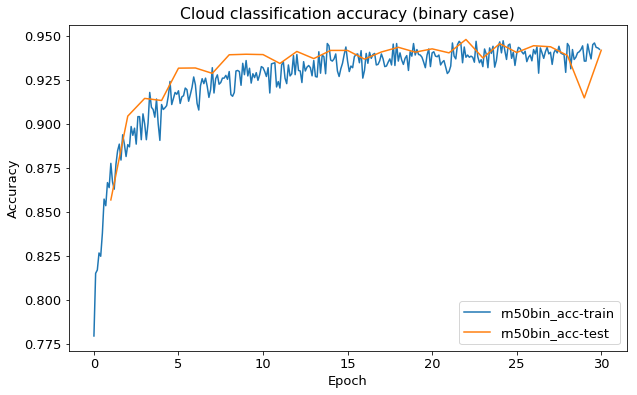

In [18]:
x = np.linspace(0, 30, 301)
plt.plot(x[:len(rn50bin_acc['train'])],          rn50bin_acc['train'], label='rn50bin_acc-train')
plt.plot(x[::10][1:len(rn50bin_acc['valid'])+1], rn50bin_acc['valid'], label='rn50bin_acc-test')
plt.title('Cloud classification accuracy (binary case)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams.update({'font.size': 13})
plt.show()

In [46]:
rn50bin.load_params(os.path.join(checkpoints, '23-0.params'),ctx)
preds, labels = get_predictions(gluon.data.DataLoader(validIterBin, 32), rn50bin)

Normalized confusion matrix
[[0.96805654 0.03194346]
 [0.11330049 0.88669951]]


array([[6849,  226],
       [ 345, 2700]])

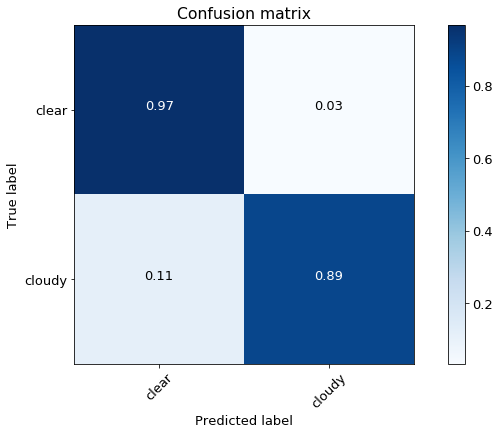

In [47]:
cm = confusion_matrix(labels, preds)
plot_confusion_matrix(cm, ['clear', 'cloudy'], normalize=True)
cm

### Testing with data from Sentinel-2

In [12]:
test_bin  = os.path.join(DATA_DIR, 'test/s2test-binary.rec')

testIterBin = ImageRecordDataset(
    filename=test_bin,
    transform=lambda X, y: transform(X, y, test_augs)
)

In [63]:
preds, labels = get_predictions(gluon.data.DataLoader(testIterBin, 32), rn50bin)

Normalized confusion matrix
[[0.81217617 0.18782383]
 [0.05302403 0.94697597]]


array([[ 627,  145],
       [  64, 1143]])

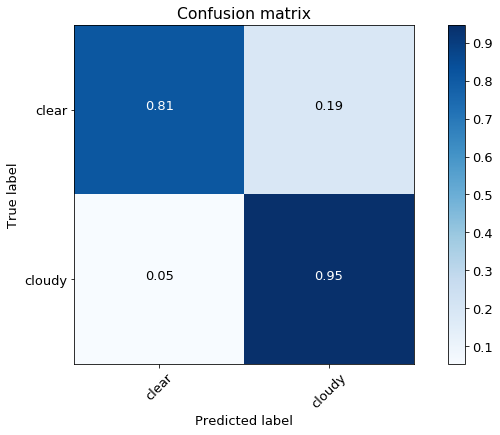

In [64]:
cm = confusion_matrix(labels, preds)
plot_confusion_matrix(cm, ['clear', 'cloudy'], normalize=True)
cm

Accuracy is not as high as before, but precision is still very good. Almost no cloudy images are getting missclassified as clear, which was our main goal.